<a href="https://colab.research.google.com/github/iamabhishek2828/Brain-Tumor/blob/Tumor/TumorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"chabhishek28","key":"153f722528b20f26bfb6bd2f5fe2ca13"}'}

In [ ]:
!mv 'kaggle (2).json' kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pkdarabi/medical-image-dataset-brain-tumor-detection
!unzip -q medical-image-dataset-brain-tumor-detection.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 86% 97.0M/113M [00:01<00:00, 98.5MB/s]
100% 113M/113M [00:01<00:00, 89.0MB/s] 


In [ ]:
pip install tensorflow keras numpy pandas scikit-learn matplotlib


In [ ]:
!pip install ultralytics
from IPython import display
display.clear_output()

In [ ]:
import os
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
T_Model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 125MB/s]


# **Data Loading**


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Set paths
dataset_path = 'dataset'
sub_dirs = ['BrainTumorDetectionYolov9/BrainTumorDetectionYolov9', 'TumorDetectionYolov8/OD8/Brain Tumor Detection']
image_types = ['train', 'test', 'valid']

# Parameters
num_images = 3000
img_size = (224, 224)
batch_size = 32

def get_image_label_pairs(sub_dirs, image_types, dataset_path, num_images):
    image_label_pairs = []
    for sub_dir in sub_dirs:
        for img_type in image_types:
            img_path = os.path.join(dataset_path, sub_dir, img_type, 'images')
            label_path = os.path.join(dataset_path, sub_dir, img_type, 'labels')
            if not os.path.exists(img_path) or not os.path.exists(label_path):
                continue
            img_files = os.listdir(img_path)
            selected_files = random.sample(img_files, min(len(img_files), num_images // len(sub_dirs)))

            for img_file in selected_files:
                image_file_path = os.path.join(img_path, img_file)
                label_file = img_file.replace('.jpg', '.txt')
                label_file_path = os.path.join(label_path, label_file)

                if os.path.exists(label_file_path):
                    with open(label_file_path, 'r') as f:
                        lines = f.readlines()
                        label = 1 if len(lines) > 0 else 0
                else:
                    label = 0

                image_label_pairs.append((image_file_path, label))

    random.shuffle(image_label_pairs)
    return image_label_pairs

def image_label_generator(image_label_pairs, batch_size, img_size):
    while True:
        batch_images = []
        batch_labels = []
        for image_path, label in image_label_pairs:
            image = load_img(image_path, target_size=img_size)
            image = img_to_array(image) / 255.0
            batch_images.append(image)
            batch_labels.append(label)
            if len(batch_images) == batch_size:
                yield np.array(batch_images), np.array(batch_labels)
                batch_images = []
                batch_labels = []

        if batch_images:
            yield np.array(batch_images), np.array(batch_labels)

image_label_pairs = get_image_label_pairs(sub_dirs, ['train'], dataset_path, num_images)
train_pairs, val_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)

train_generator = image_label_generator(train_pairs, batch_size, img_size)
val_generator = image_label_generator(val_pairs, batch_size, img_size)
steps_per_epoch = len(train_pairs) // batch_size
validation_steps = len(val_pairs) // batch_size



# **Using Yolov8 for training model**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load and preprocess the data
data_dir = '/content/dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection'
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)




Found 7920 images belonging to 3 classes.
Found 1980 images belonging to 3 classes.


# **CNN with Yolov8 Training**

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=50)

# Save the model
cnn_model_path = '/content/cnn_model.h5'
model.save(cnn_model_path)

print(f"Pre-trained CNN model saved to {cnn_model_path}")

Epoch 1/50
248/248 [==============================] - 29s 93ms/step - loss: -409142112.0000 - accuracy: 0.6985 - val_loss: -3325171712.0000 - val_accuracy: 0.7000
Epoch 2/50
248/248 [==============================] - 16s 65ms/step - loss: -43797766144.0000 - accuracy: 0.7000 - val_loss: -168958885888.0000 - val_accuracy: 0.7000
Epoch 3/50
248/248 [==============================] - 19s 75ms/step - loss: -554264100864.0000 - accuracy: 0.7000 - val_loss: -1465503842304.0000 - val_accuracy: 0.7000
Epoch 4/50
248/248 [==============================] - 17s 67ms/step - loss: -2952568504320.0000 - accuracy: 0.7000 - val_loss: -6240200032256.0000 - val_accuracy: 0.7000
Epoch 5/50
248/248 [==============================] - 17s 67ms/step - loss: -10235103150080.0000 - accuracy: 0.7000 - val_loss: -18533576605696.0000 - val_accuracy: 0.7000
Epoch 6/50
248/248 [==============================] - 16s 65ms/step - loss: -27298875047936.0000 - accuracy: 0.7000 - val_loss: -45001820078080.0000 - val_accu

In [ ]:
pip install ultralytics


In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # You can use 'yolov8s.pt', 'yolov8m.pt', etc.

# Define the dataset configuration YAML file path
yaml_file_path = '/content/dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/data.yaml'

# Train the YOLOv8 model with a supported optimizer
results = model.train(
    data=yaml_file_path,
    epochs=10,
    batch=32,
    optimizer='Adam',  # Correct optimizer name
    patience=20
)

print("YOLOv8 training completed.")




Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/data.yaml, epochs=10, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

train: Scanning /content/dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/labels.cache... 6930 images, 79 backgrounds, 0 corrupt: 100%|██████████| 6930/6930 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/valid/labels.cache... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.29G      2.131      2.946      2.357         37        640: 100%|██████████| 217/217 [01:57<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


                   all       1980       4380    0.00943      0.192    0.00632    0.00193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.61G      2.084       2.66      2.302         45        640: 100%|██████████| 217/217 [02:00<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:27<00:00,  1.13it/s]


                   all       1980       4380       0.13      0.204     0.0725     0.0224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.59G      2.004      2.472      2.223         38        640: 100%|██████████| 217/217 [01:54<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]


                   all       1980       4380      0.152      0.259      0.122     0.0395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       4.6G      1.964      2.369       2.18         29        640: 100%|██████████| 217/217 [01:55<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]


                   all       1980       4380      0.277      0.234      0.157      0.047

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.59G        1.9      2.232       2.12         38        640: 100%|██████████| 217/217 [02:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]


                   all       1980       4380       0.34      0.322      0.296       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.59G      1.869      2.147      2.079         37        640: 100%|██████████| 217/217 [01:53<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]

                   all       1980       4380      0.486      0.408      0.422      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.58G      1.815      2.021      2.015         36        640: 100%|██████████| 217/217 [01:51<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]

                   all       1980       4380      0.467      0.421        0.4      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.59G      1.783      1.948      1.988         41        640: 100%|██████████| 217/217 [01:52<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]


                   all       1980       4380      0.524      0.481      0.472      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.58G      1.734      1.851      1.948         37        640: 100%|██████████| 217/217 [01:52<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]

                   all       1980       4380      0.611      0.476      0.496      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.59G      1.697      1.752       1.92         49        640: 100%|██████████| 217/217 [01:52<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:18<00:00,  1.64it/s]


                   all       1980       4380      0.662      0.511      0.542       0.27

10 epochs completed in 0.386 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


                   all       1980       4380      0.664       0.51      0.542       0.27
                label0       1246       1246      0.557      0.406      0.413       0.17
                label1       1944       1944      0.788      0.687       0.73      0.417
                label2       1190       1190      0.647      0.437      0.482      0.224
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train5
YOLOv8 training completed.


# Results

In [ ]:
import os
import cv2
from ultralytics import YOLO
from PIL import Image
import numpy as np

# Load the trained model
model = YOLO('runs/detect/train/weights/best.pt')

# Path to your validation images
image_path = '/content/dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/valid/images'

if os.path.exists(image_path):
    print("Path exists!")

    # Ensure the save directory exists
    save_directory = '/content/runs/detect/train2/results/'
    os.makedirs(save_directory, exist_ok=True)

    # List all images in the directory and filter out non-jpg files
    all_images = [f for f in os.listdir(image_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Limit to first 10 images
    num_images_to_process = min(10, len(all_images))

    # Loop through the first 10 images in the validation set
    for i in range(num_images_to_process):
        img_file = all_images[i]
        img_path = os.path.join(image_path, img_file)

        # Read the image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image {img_path}")
            continue

        # Perform inference
        results = model(image)

        # Process each result (in case of batch processing)
        for result in results:
            # Display results
            print(f"Detected {len(result.boxes)} objects in {img_file}")

            # Save the annotated image
            save_path = os.path.join(save_directory, img_file)

            # Convert image to RGB (PIL uses RGB)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Convert numpy array to PIL Image
            pil_image = Image.fromarray(image_rgb)

            # Plot and save the image using PIL
            annotated_image = result.plot()  # Plot the annotated results
            if annotated_image is not None:
                # Convert annotated_image to PIL Image
                pil_annotated_image = Image.fromarray(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
                pil_annotated_image.save(save_path)  # Save the image using PIL
                print(f"Saved annotated image to {save_path}")
            else:
                print(f"Failed to plot annotated image for {img_file}")

else:
    print("Path does not exist!")



Path exists!

0: 608x640 2 label1s, 23.1ms
Speed: 2.8ms preprocess, 23.1ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)
Detected 2 objects in volume_8_slice_63_jpg.rf.249f150f79af7205a3bbb41ab1cd87bb.jpg
Saved annotated image to /content/runs/detect/train2/results/volume_8_slice_63_jpg.rf.249f150f79af7205a3bbb41ab1cd87bb.jpg

0: 608x640 (no detections), 19.8ms
Speed: 2.6ms preprocess, 19.8ms inference, 10.9ms postprocess per image at shape (1, 3, 608, 640)
Detected 0 objects in volume_79_slice_123_jpg.rf.07d6075d6802eb236f548202ee4b36ee.jpg
Saved annotated image to /content/runs/detect/train2/results/volume_79_slice_123_jpg.rf.07d6075d6802eb236f548202ee4b36ee.jpg

0: 608x640 2 label1s, 1 label2, 19.3ms
Speed: 3.8ms preprocess, 19.3ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)
Detected 3 objects in volume_65_slice_73_jpg.rf.1704e7fdb8d43e1d8f10ae55a60415f8.jpg
Saved annotated image to /content/runs/detect/train2/results/volume_65_slice_73_jpg.rf

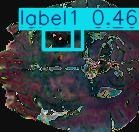

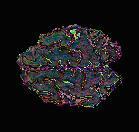

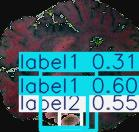

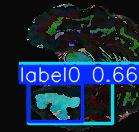

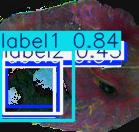

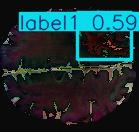

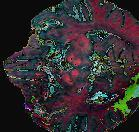

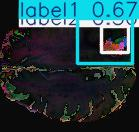

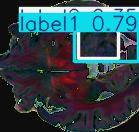

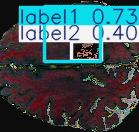

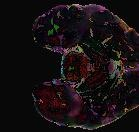

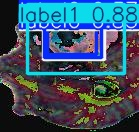

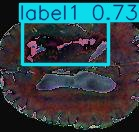

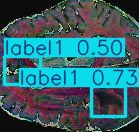

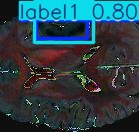

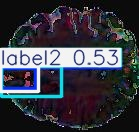

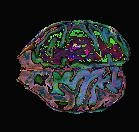

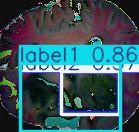

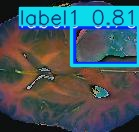

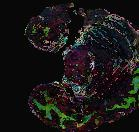

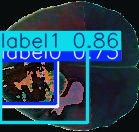

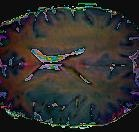

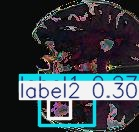

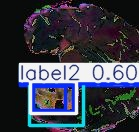

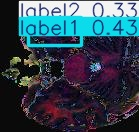

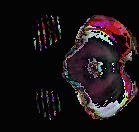

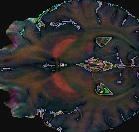

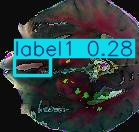

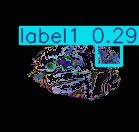

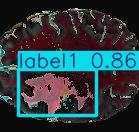

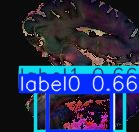

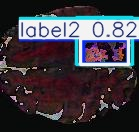

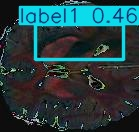

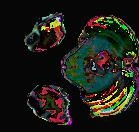

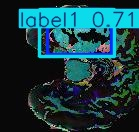

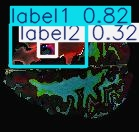

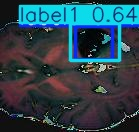

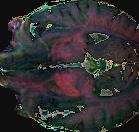

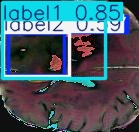

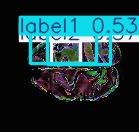

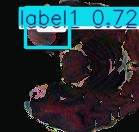

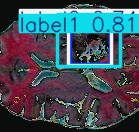

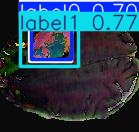

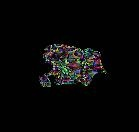

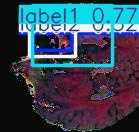

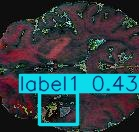

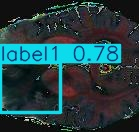

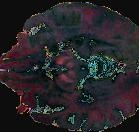

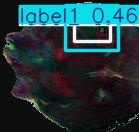

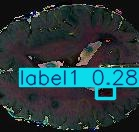

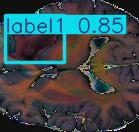

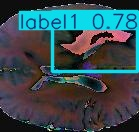

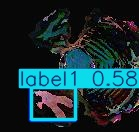

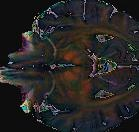

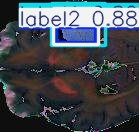

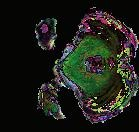

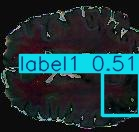

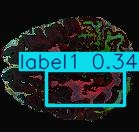

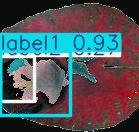

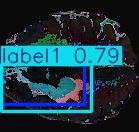

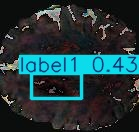

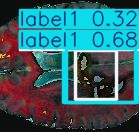

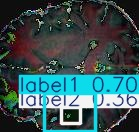

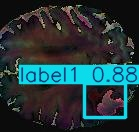

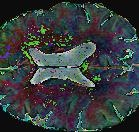

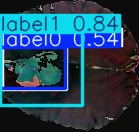

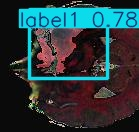

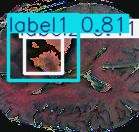

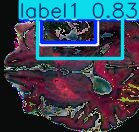

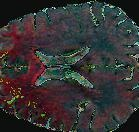

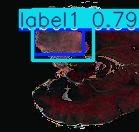

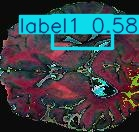

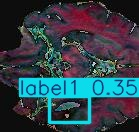

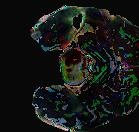

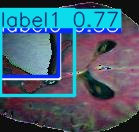

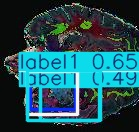

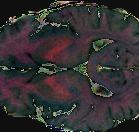

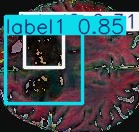

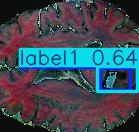

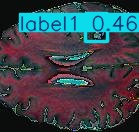

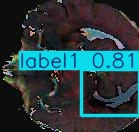

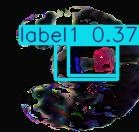

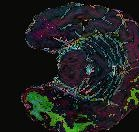

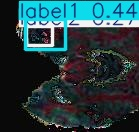

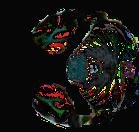

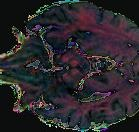

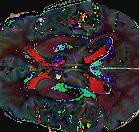

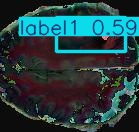

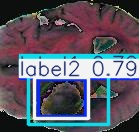

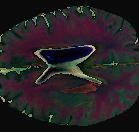

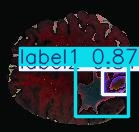

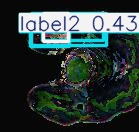

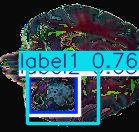

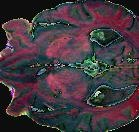

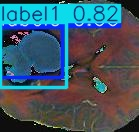

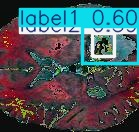

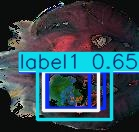

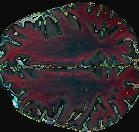

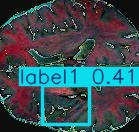

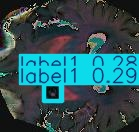

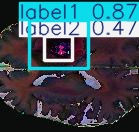

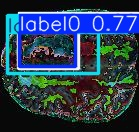

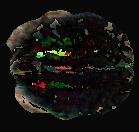

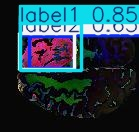

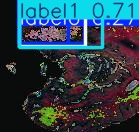

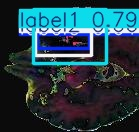

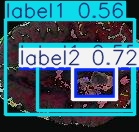

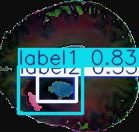

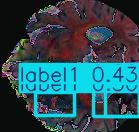

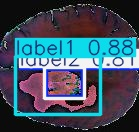

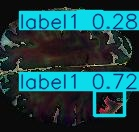

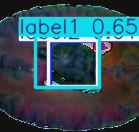

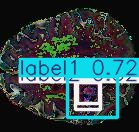

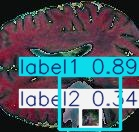

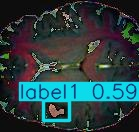

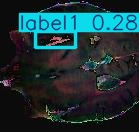

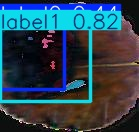

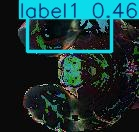

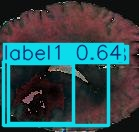

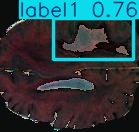

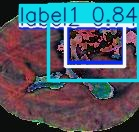

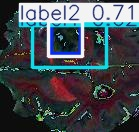

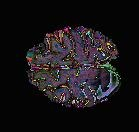

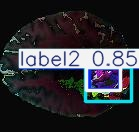

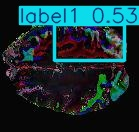

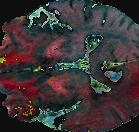

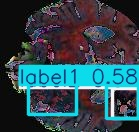

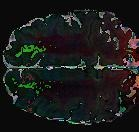

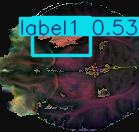

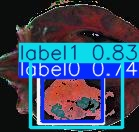

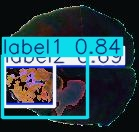

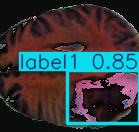

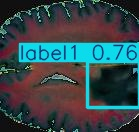

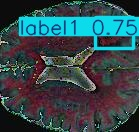

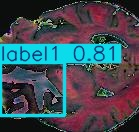

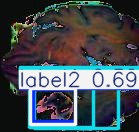

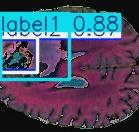

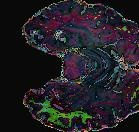

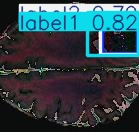

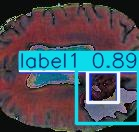

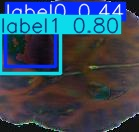

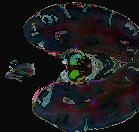

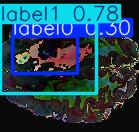

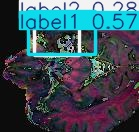

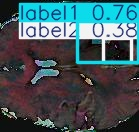

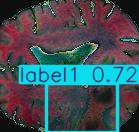

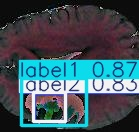

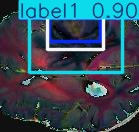

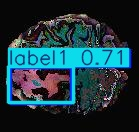

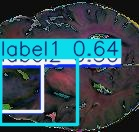

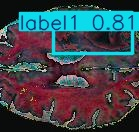

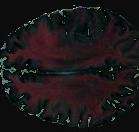

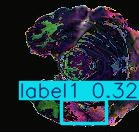

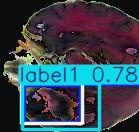

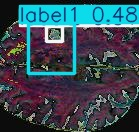

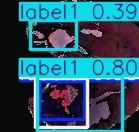

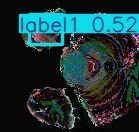

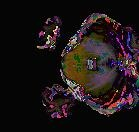

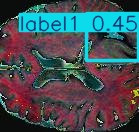

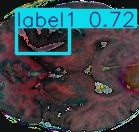

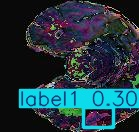

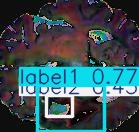

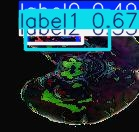

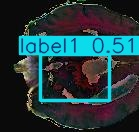

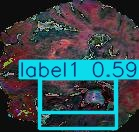

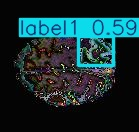

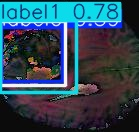

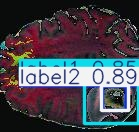

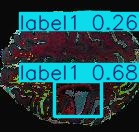

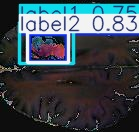

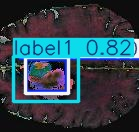

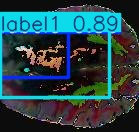

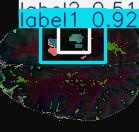

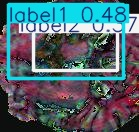

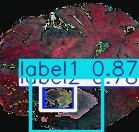

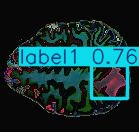

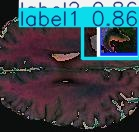

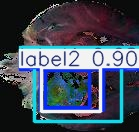

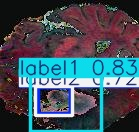

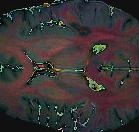

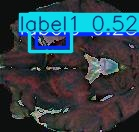

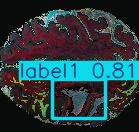

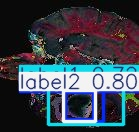

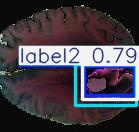

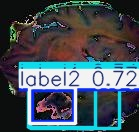

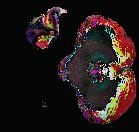

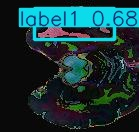

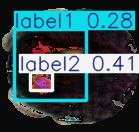

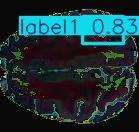

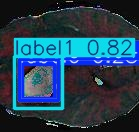

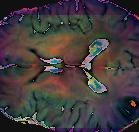

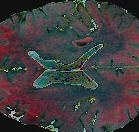

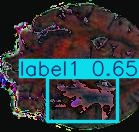

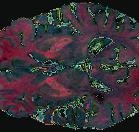

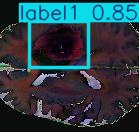

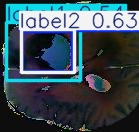

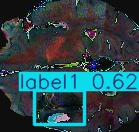

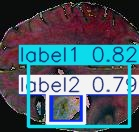

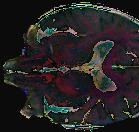

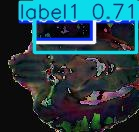

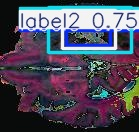

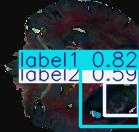

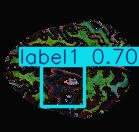

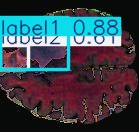

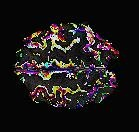

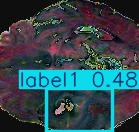

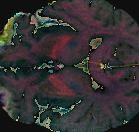

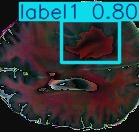

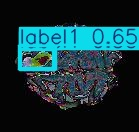

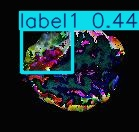

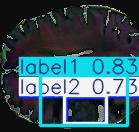

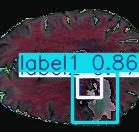

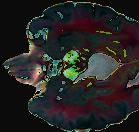

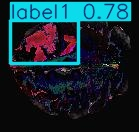

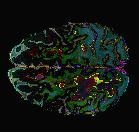

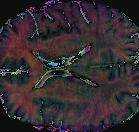

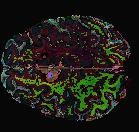

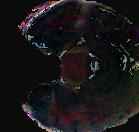

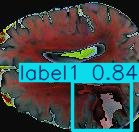

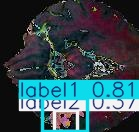

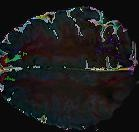

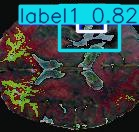

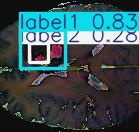

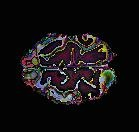

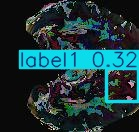

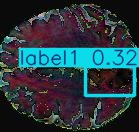

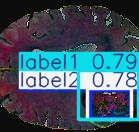

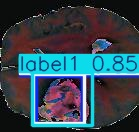

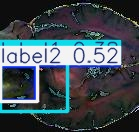

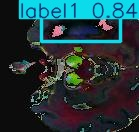

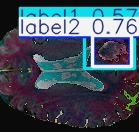

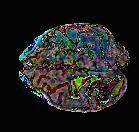

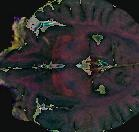

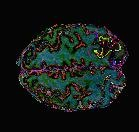

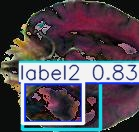

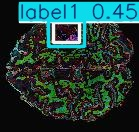

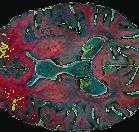

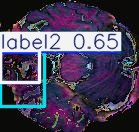

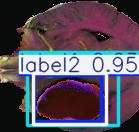

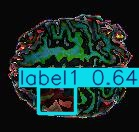

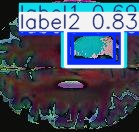

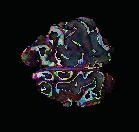

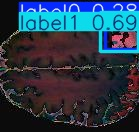

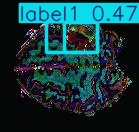

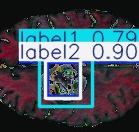

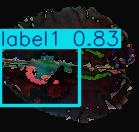

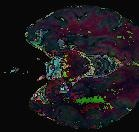

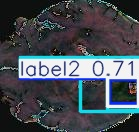

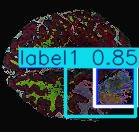

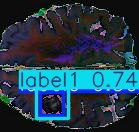

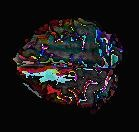

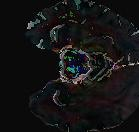

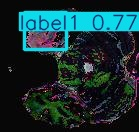

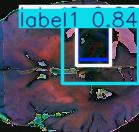

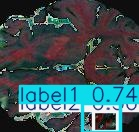

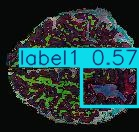

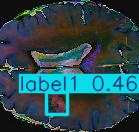

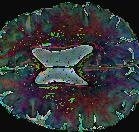

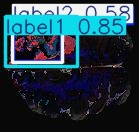

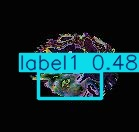

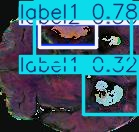

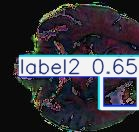

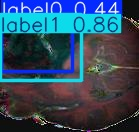

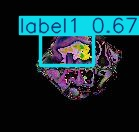

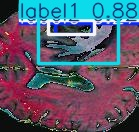

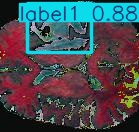

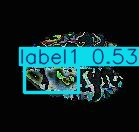

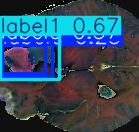

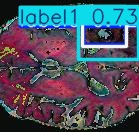

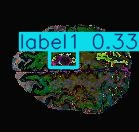

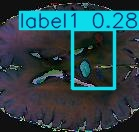

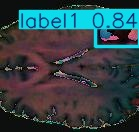

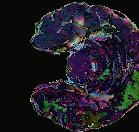

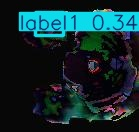

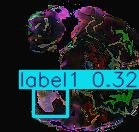

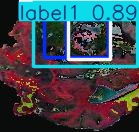

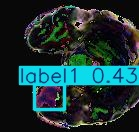

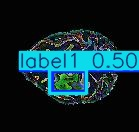

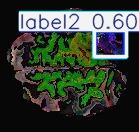

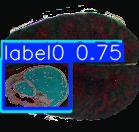

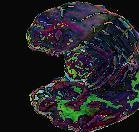

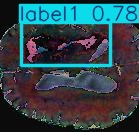

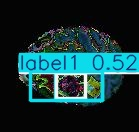

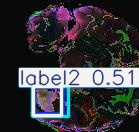

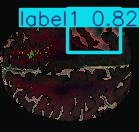

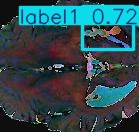

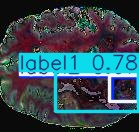

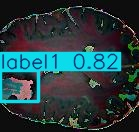

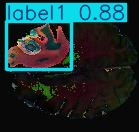

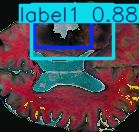

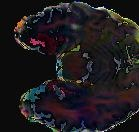

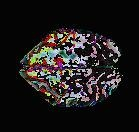

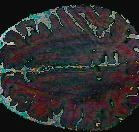

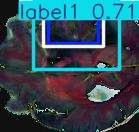

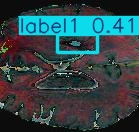

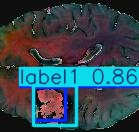

In [ ]:
from IPython.display import Image, display
import os

result_folder = '/content/runs/detect/train2/results/'

for img_name in os.listdir(result_folder):
    display(Image(filename=os.path.join(result_folder, img_name)))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = [0, 1, 1, 0]  # Example ground truth
y_pred = [0, 1, 0, 0]  # Example predictions

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')



Accuracy: 0.75
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666


# **CNN with Yolov9**

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('yolov8n.pt')  # or 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt'

# Train the model
model.train(data='/content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/data.yaml', epochs=10, imgsz=640)

# Validate the model
results = model.val(data='/content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/data.yaml', imgsz=640)

# Print results
print(results)


Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

train: Scanning /content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/labels... 6930 images, 79 backgrounds, 0 corrupt: 100%|██████████| 6930/6930 [00:04<00:00, 1449.54it/s]


train: New cache created: /content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/valid/labels... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:01<00:00, 1048.59it/s]


val: New cache created: /content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/valid/labels.cache
Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.84G      1.878      3.095      2.083          5        640: 100%|██████████| 434/434 [02:15<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:19<00:00,  3.22it/s]


                   all       1980       4380      0.352       0.34      0.294      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.38G      1.843      2.324      2.056          4        640: 100%|██████████| 434/434 [02:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


                   all       1980       4380      0.454       0.39      0.383      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.37G      1.825      2.083      2.013          6        640: 100%|██████████| 434/434 [02:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


                   all       1980       4380      0.476      0.364      0.375      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.36G      1.783      1.971      1.984          3        640: 100%|██████████| 434/434 [02:07<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.98it/s]


                   all       1980       4380      0.479      0.437      0.441      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.35G      1.722      1.797      1.908          2        640: 100%|██████████| 434/434 [02:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  3.89it/s]


                   all       1980       4380      0.638      0.504       0.53      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.35G      1.685      1.701      1.883          5        640: 100%|██████████| 434/434 [02:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  4.02it/s]


                   all       1980       4380      0.678       0.52      0.572      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.34G      1.631      1.567      1.823          6        640: 100%|██████████| 434/434 [02:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]

                   all       1980       4380       0.72      0.546      0.604      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.34G      1.597      1.486      1.797          6        640: 100%|██████████| 434/434 [02:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:18<00:00,  3.27it/s]

                   all       1980       4380      0.758      0.563      0.631      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.34G       1.55      1.407      1.764          4        640: 100%|██████████| 434/434 [02:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:18<00:00,  3.30it/s]


                   all       1980       4380      0.781      0.588      0.658      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.34G      1.513      1.331      1.728          6        640: 100%|██████████| 434/434 [02:02<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:18<00:00,  3.32it/s]

                   all       1980       4380      0.795      0.596      0.672      0.378



10 epochs completed in 0.406 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:23<00:00,  2.67it/s]


                   all       1980       4380      0.798      0.595      0.672      0.378
                label0       1246       1246      0.727      0.481      0.559      0.267
                label1       1944       1944      0.839      0.751      0.804      0.507
                label2       1190       1190      0.827      0.554      0.654      0.361
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train6
Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/valid/labels.cache... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:22<00:00,  5.53it/s]


                   all       1980       4380      0.798      0.595      0.672      0.379
                label0       1246       1246      0.728      0.481      0.559      0.267
                label1       1944       1944      0.838       0.75      0.804      0.507
                label2       1190       1190      0.827      0.554      0.654      0.361
Speed: 0.3ms preprocess, 3.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train62
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aea16ee1060>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,  

# **Results**

In [ ]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO('runs/detect/train/weights/best.pt')

# Path to your validation images
image_path = '/content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/valid/images'

if os.path.exists(image_path):
    print("Path exists!")

    # Ensure the save directory exists
    save_directory = '/content/runs/detect/train2/results/'
    os.makedirs(save_directory, exist_ok=True)

    # List all images in the directory and filter out non-jpg files
    all_images = [f for f in os.listdir(image_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Limit to first 10 images
    num_images_to_process = min(10, len(all_images))

    # Loop through the first 10 images in the validation set
    for i in range(num_images_to_process):
        img_file = all_images[i]
        img_path = os.path.join(image_path, img_file)
        image = cv2.imread(img_path)

        # Perform inference
        results = model(image)

        # Check if results contain detections
        if results[0].boxes is not None:
            print(f"Detections found in image: {img_file}")
        else:
            print(f"No detections in image: {img_file}")

        # Loop through each result
        for result in results:
            # Annotate the image
            annotated_image = result.plot()  # Render the results on the image

            # Convert BGR to RGB for matplotlib
            annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

            # Save annotated image
            save_path = os.path.join(save_directory, img_file)
            cv2.imwrite(save_path, annotated_image)

            # Display annotated image
            plt.figure(figsize=(10, 10))
            plt.imshow(annotated_image_rgb)
            plt.axis('off')
            plt.title(f'Annotated Image {i + 1}')
            plt.show()

else:
    print("Path does not exist!")



Path exists!

0: 608x640 2 label1s, 28.9ms
Speed: 2.8ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)
Detections found in image: volume_8_slice_63_jpg.rf.249f150f79af7205a3bbb41ab1cd87bb.jpg

0: 608x640 (no detections), 24.7ms
Speed: 3.6ms preprocess, 24.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)
Detections found in image: volume_79_slice_123_jpg.rf.07d6075d6802eb236f548202ee4b36ee.jpg

0: 608x640 2 label1s, 1 label2, 37.8ms
Speed: 2.8ms preprocess, 37.8ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)
Detections found in image: volume_65_slice_73_jpg.rf.1704e7fdb8d43e1d8f10ae55a60415f8.jpg

0: 608x640 1 label0, 1 label1, 17.4ms
Speed: 3.5ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)
Detections found in image: volume_309_slice_45_jpg.rf.6e51f1fa37e881fb2913894ec4b20a40.jpg

0: 608x640 2 label0s, 1 label1, 2 label2s, 18.7ms
Speed: 2.6ms preprocess, 18.7ms inference,

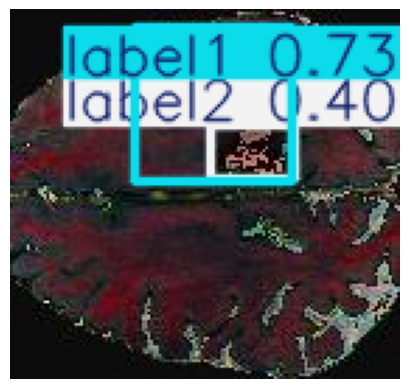

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

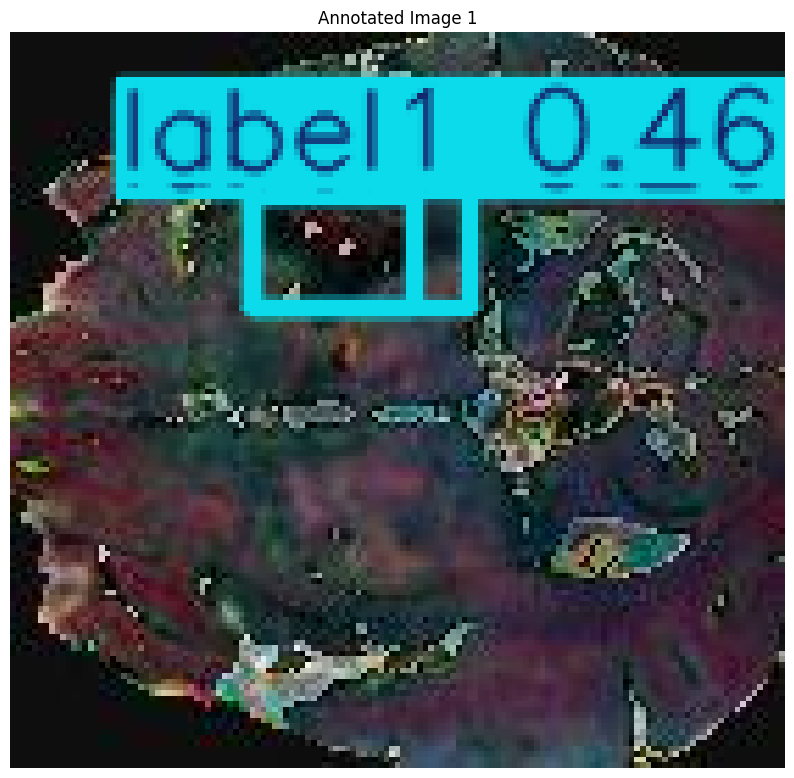

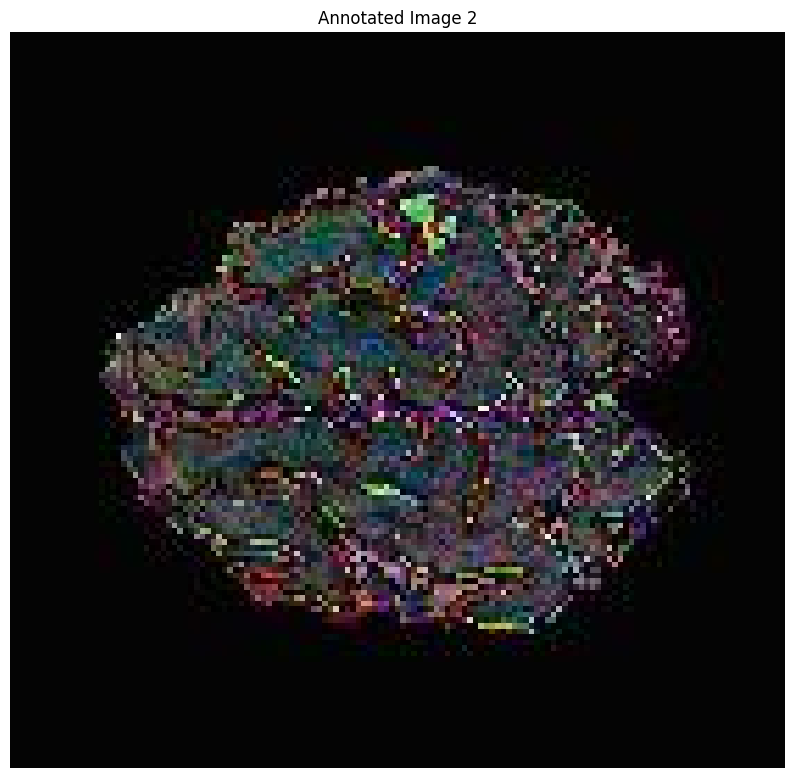

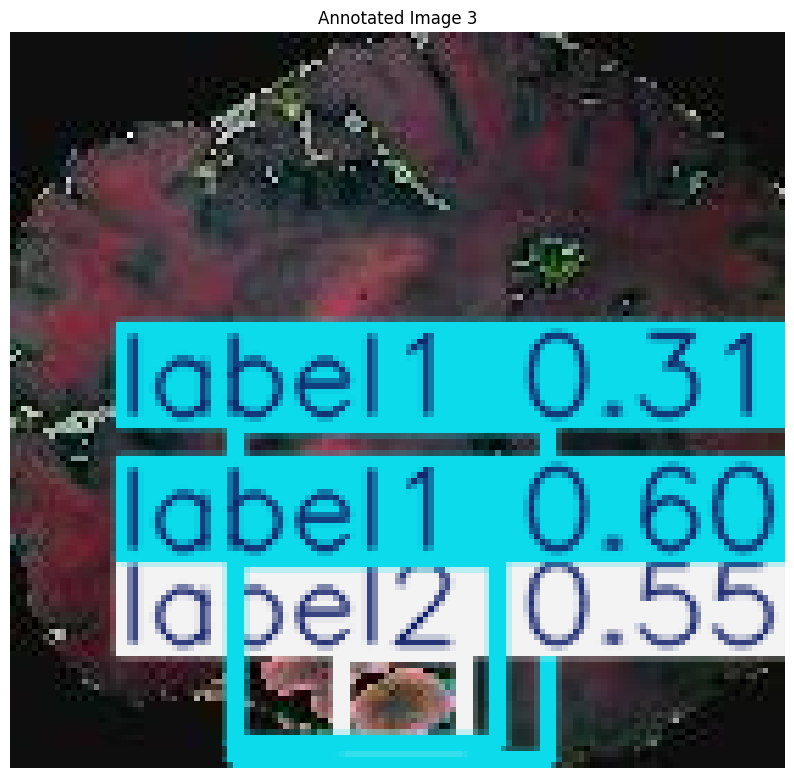

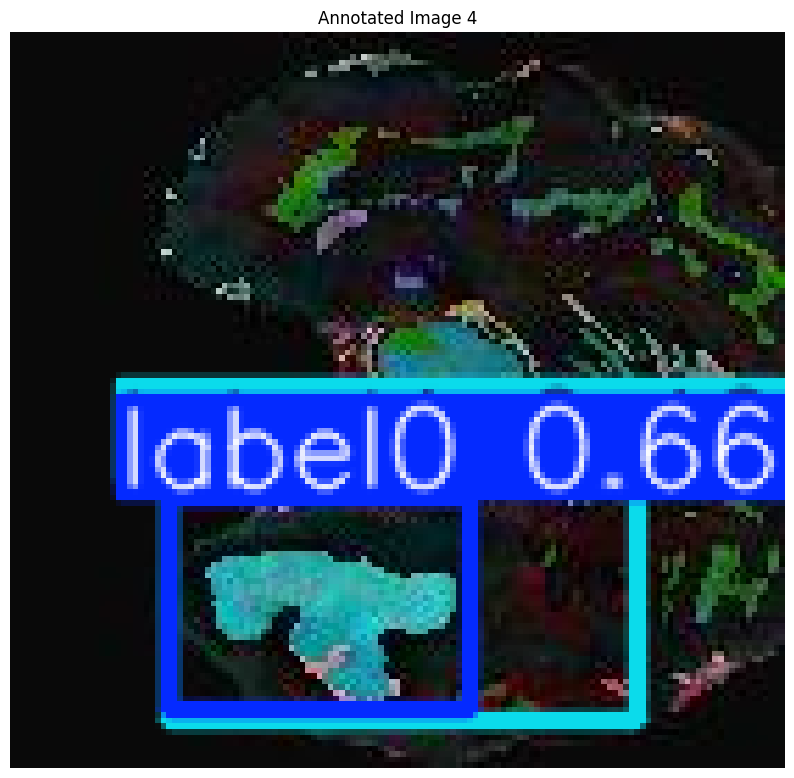

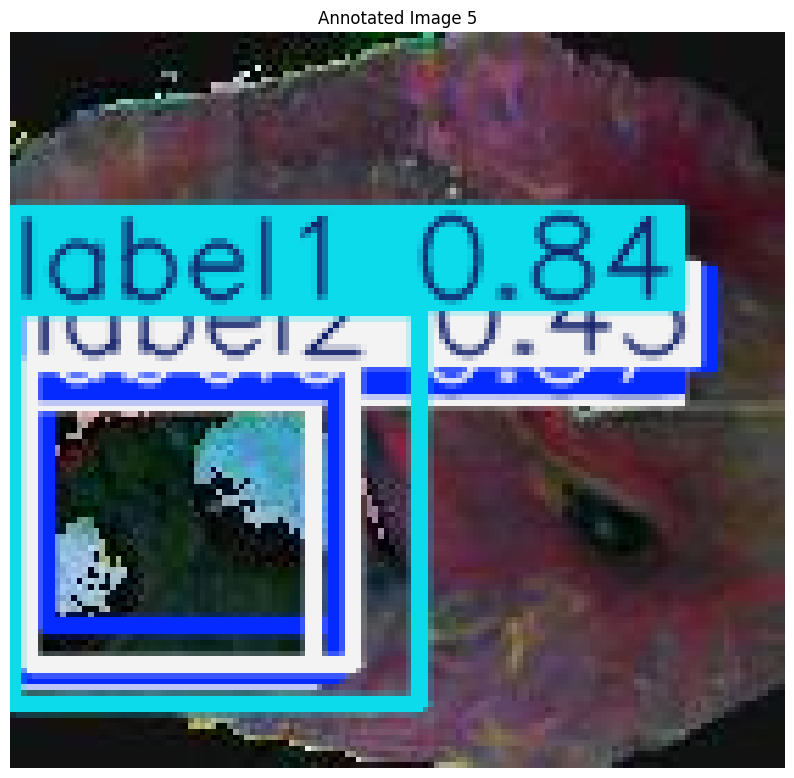

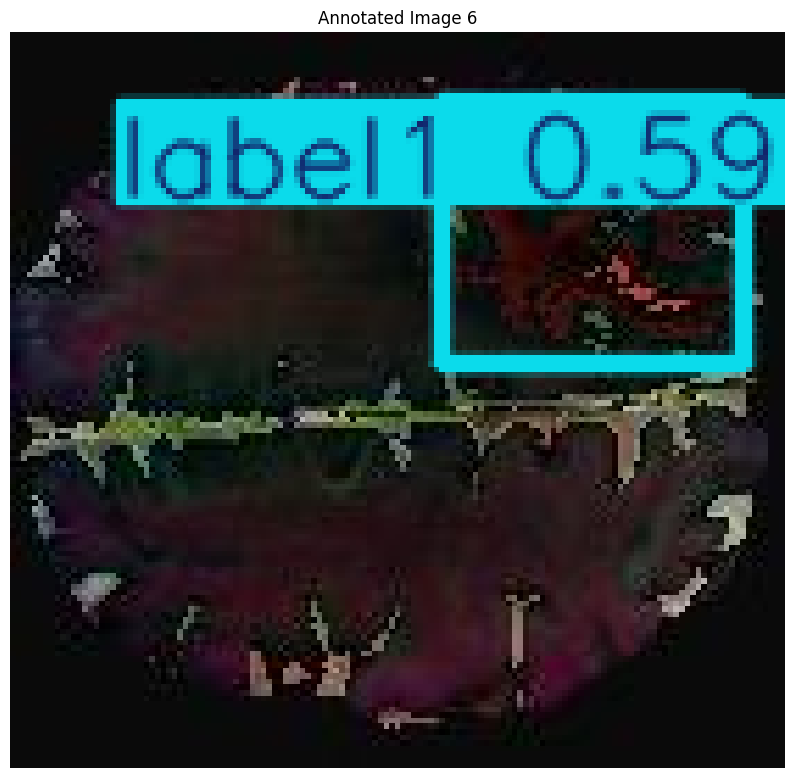

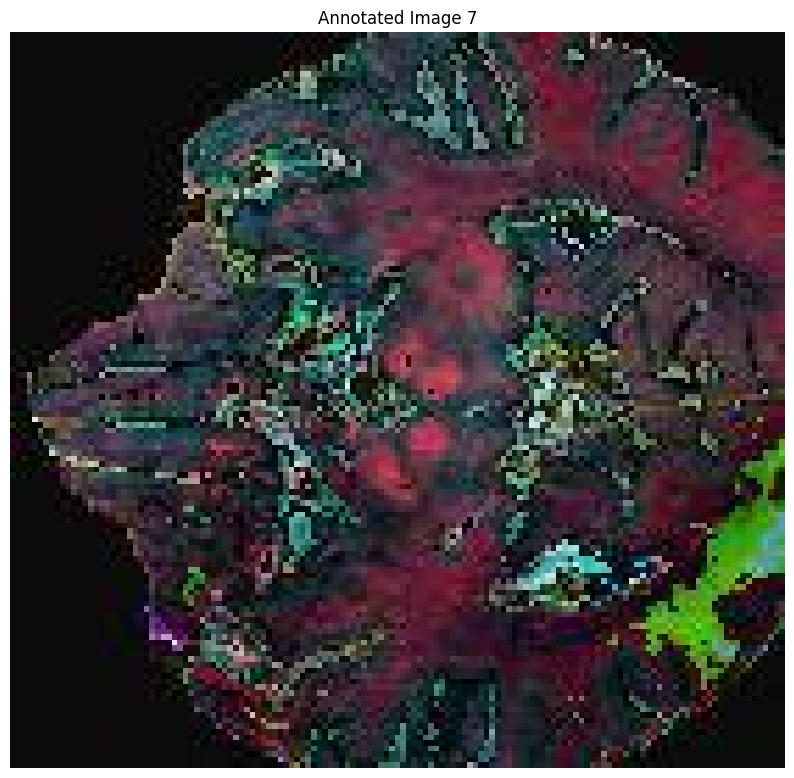

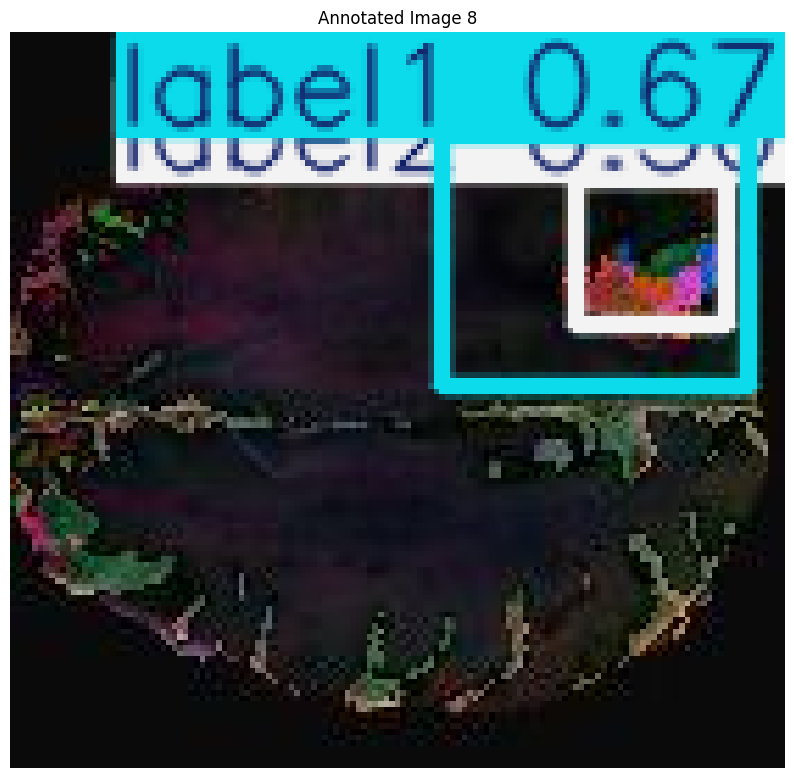

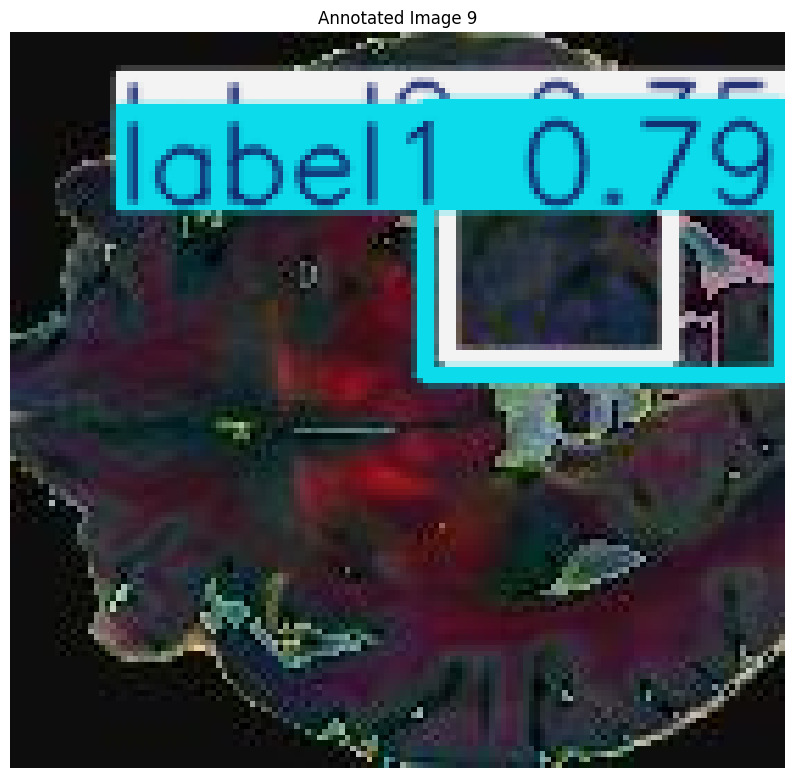

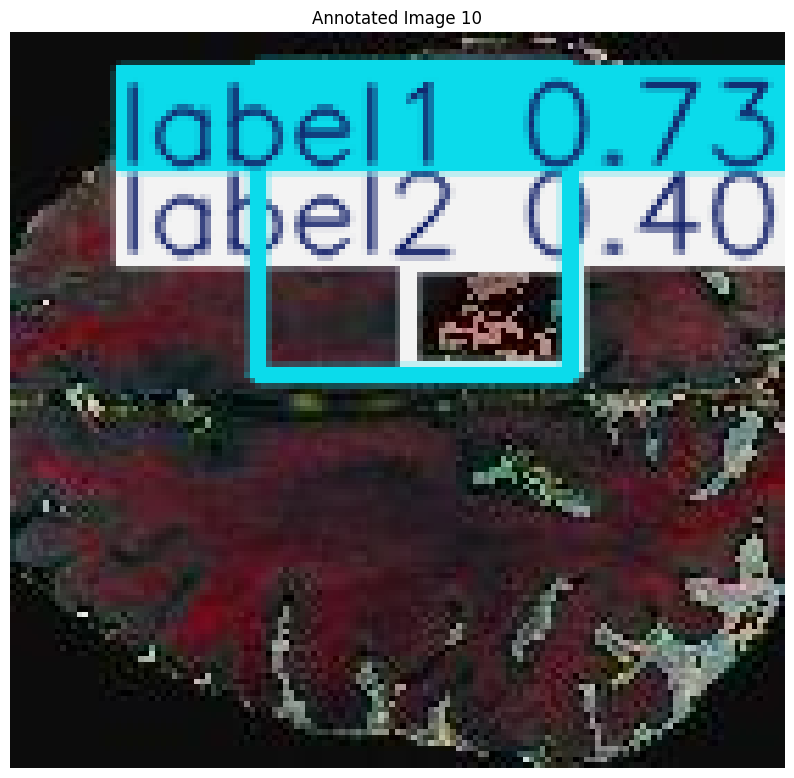

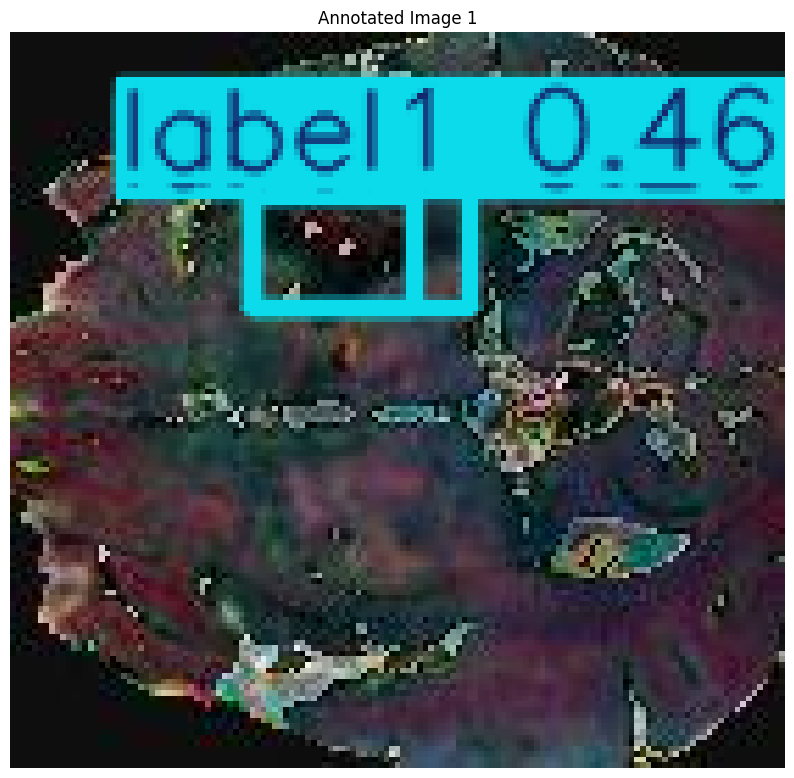

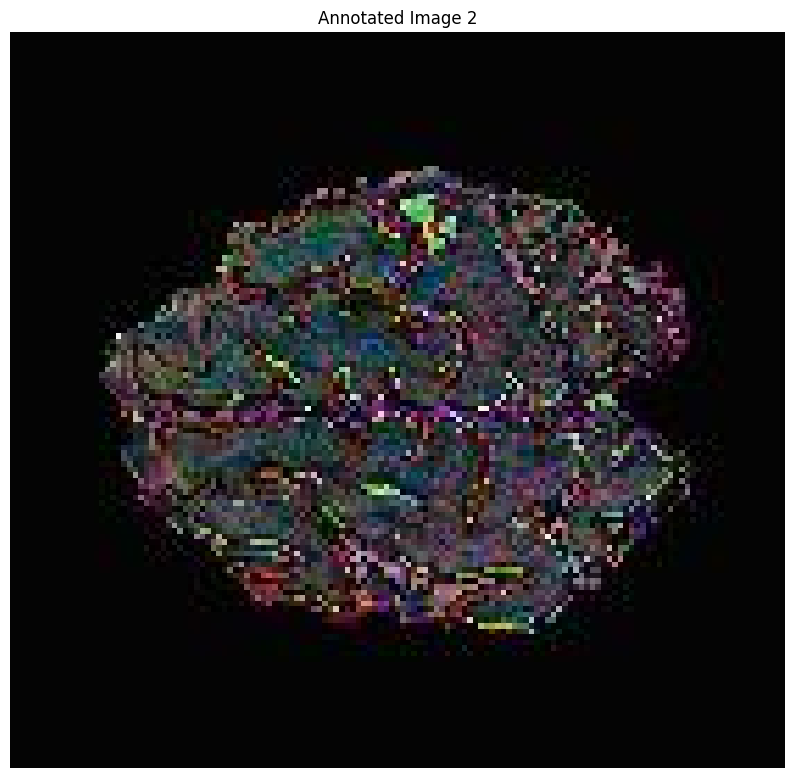

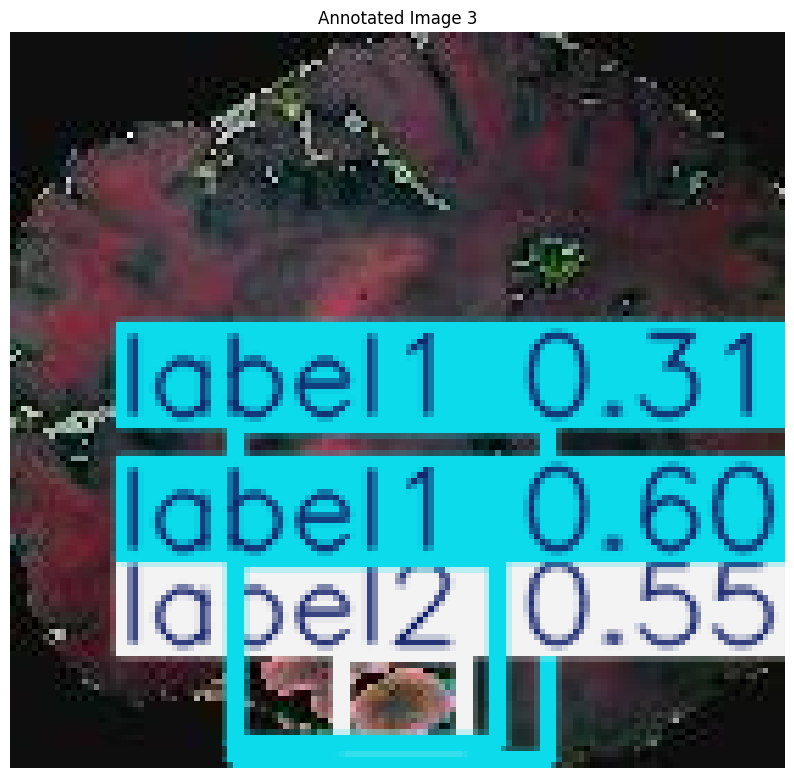

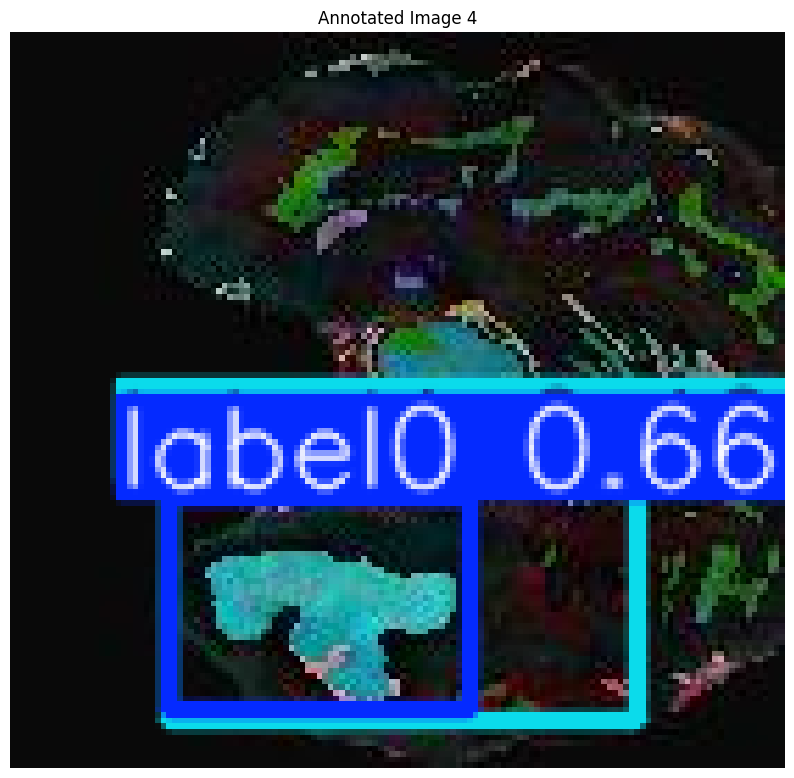

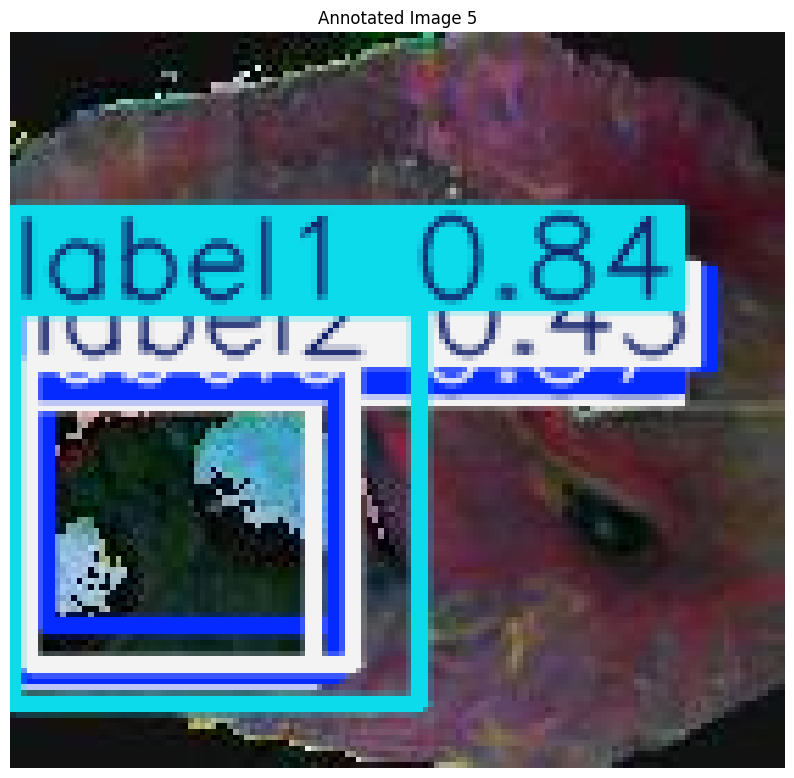

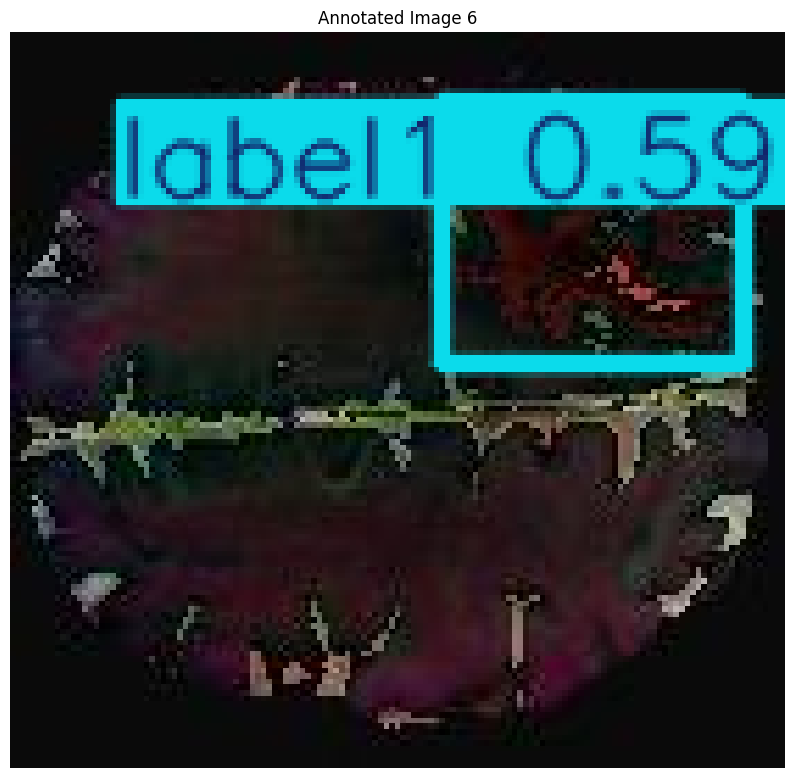

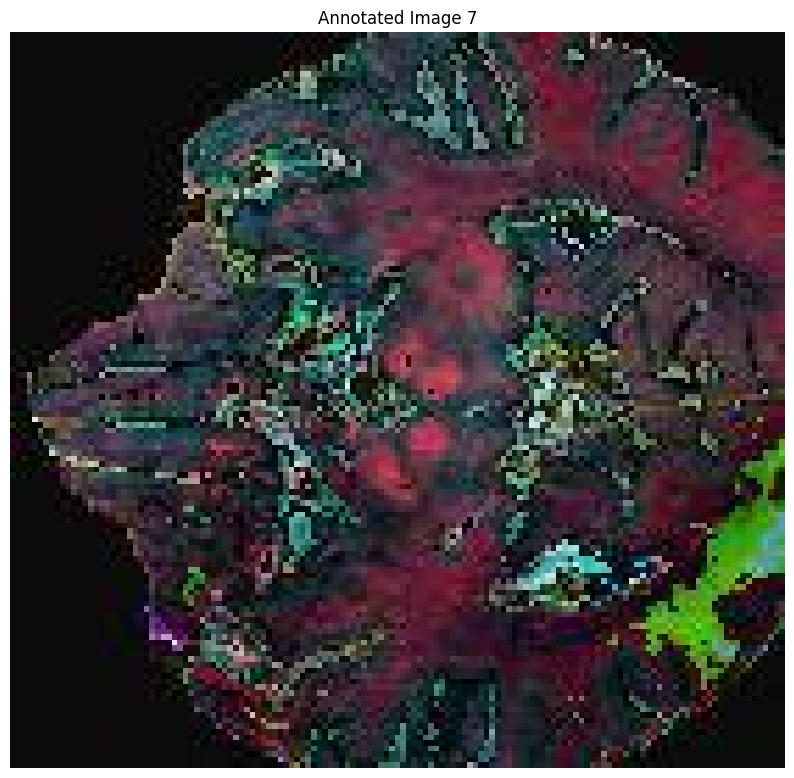

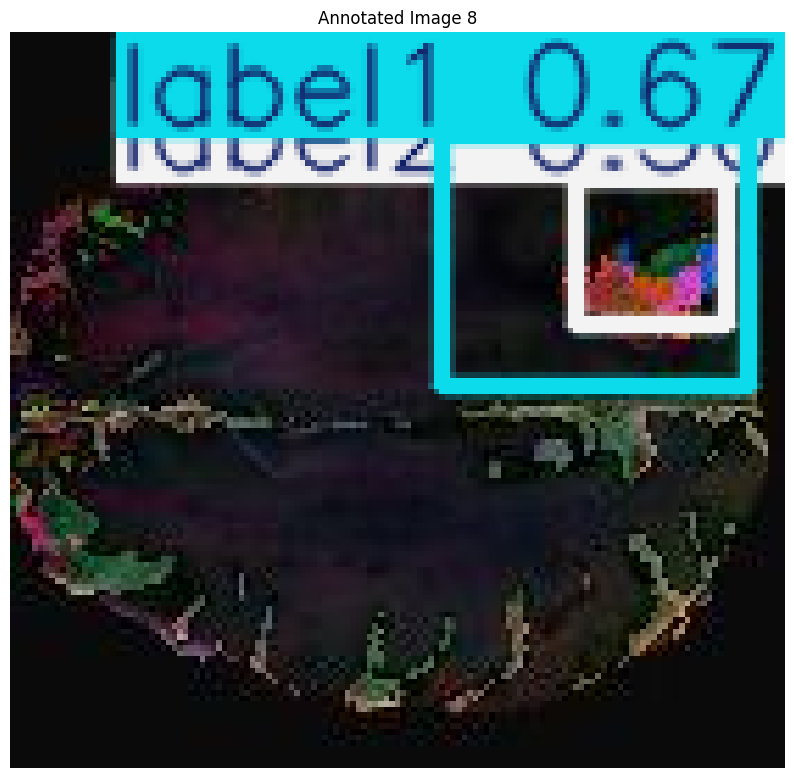

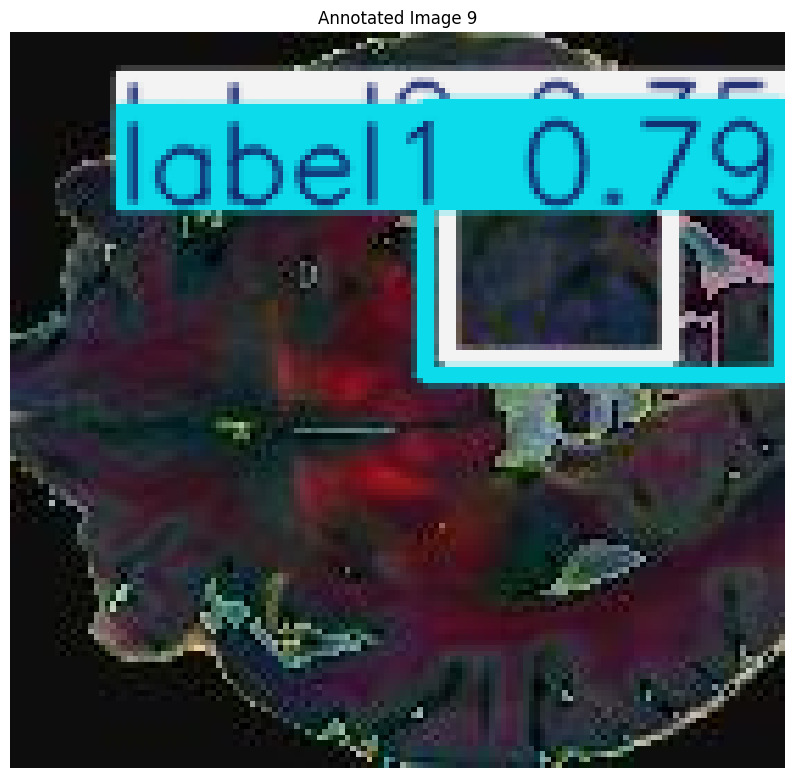

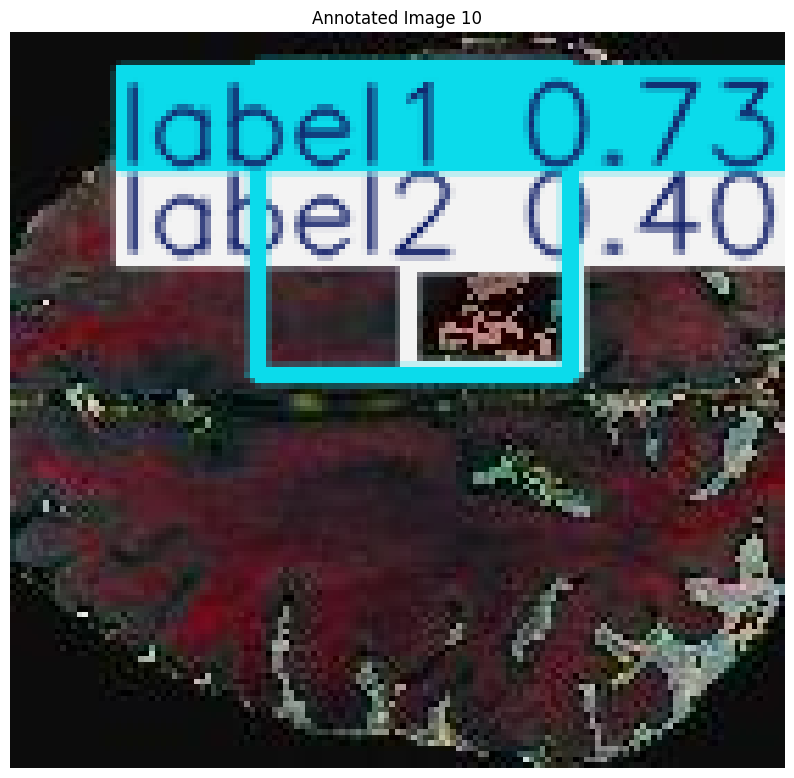

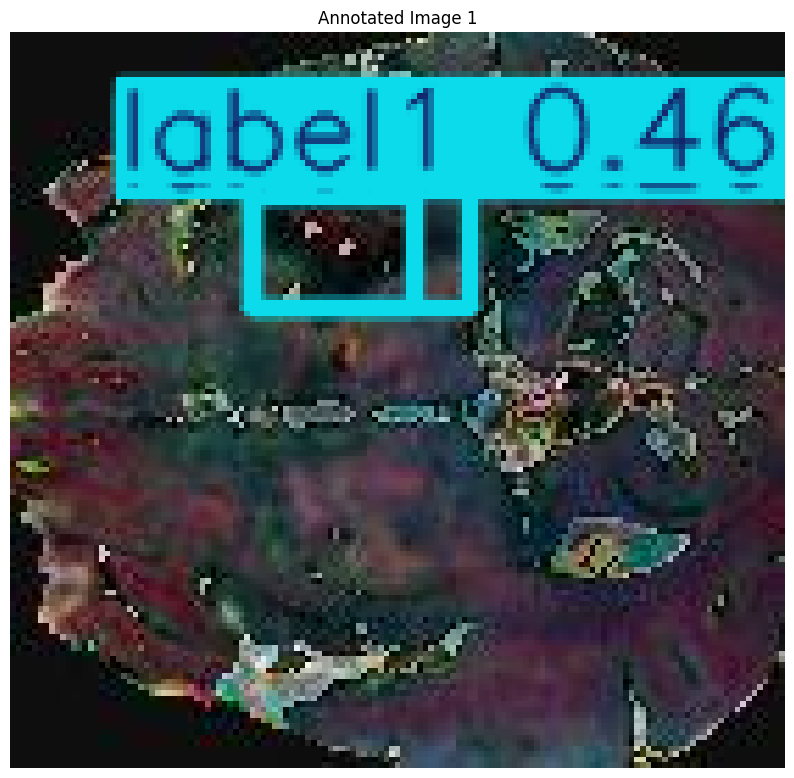

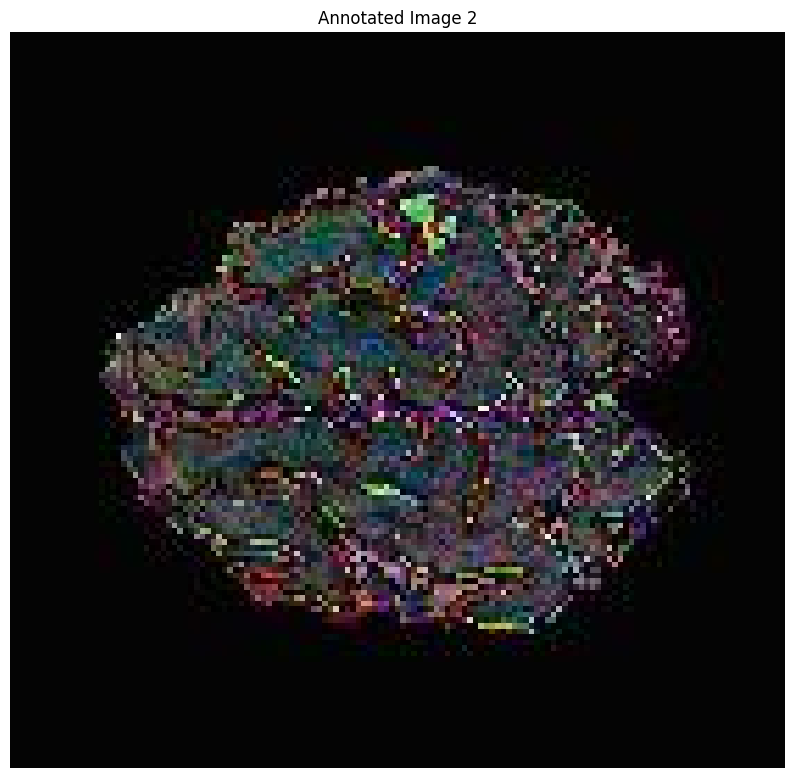

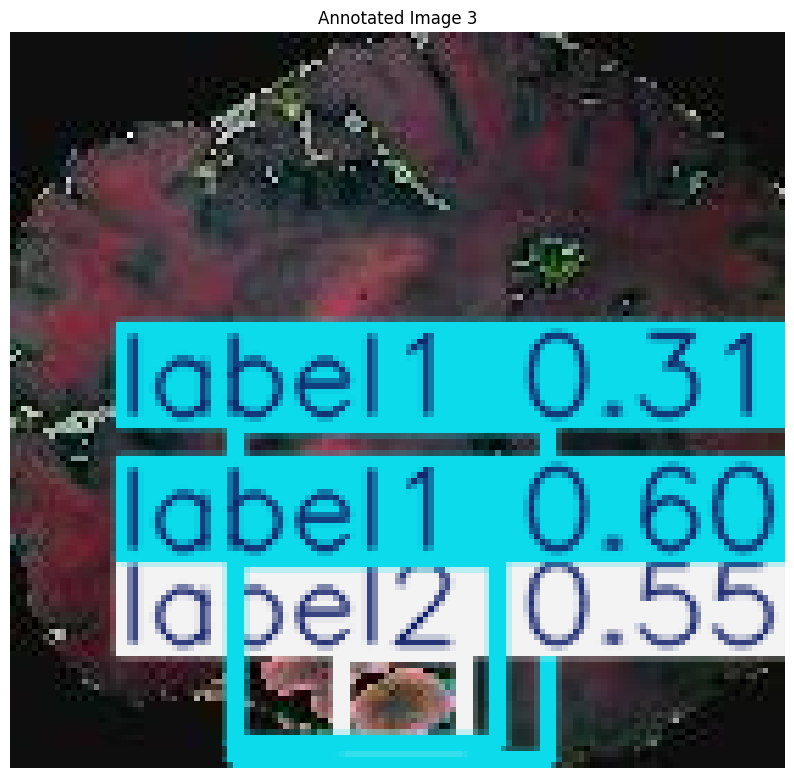

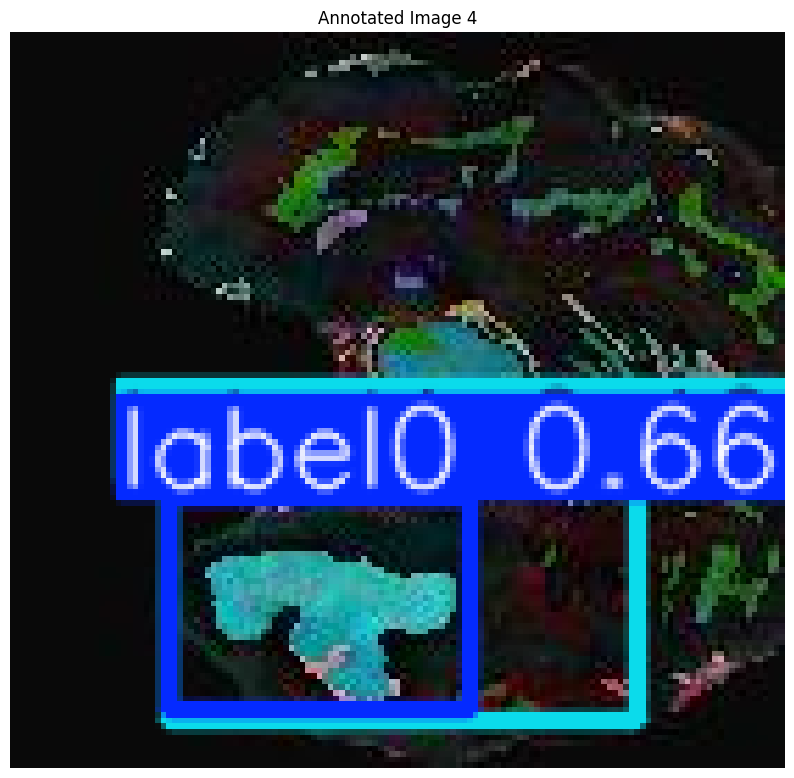

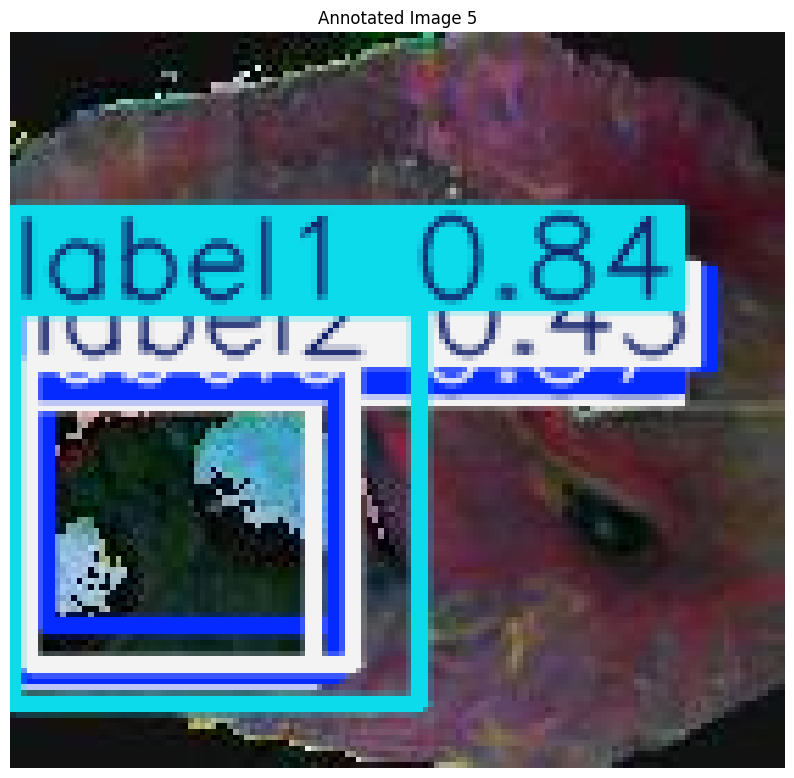

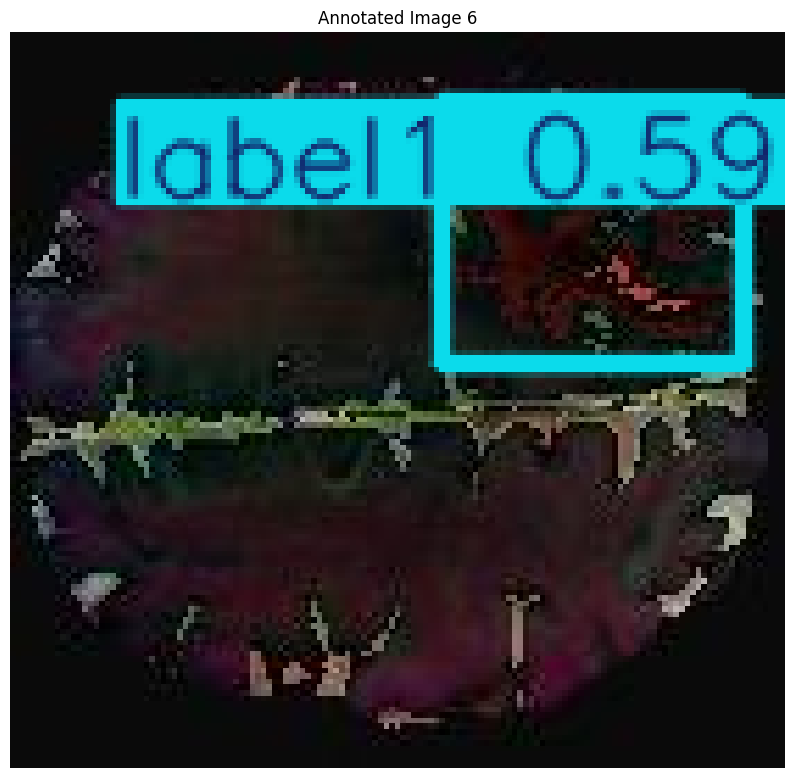

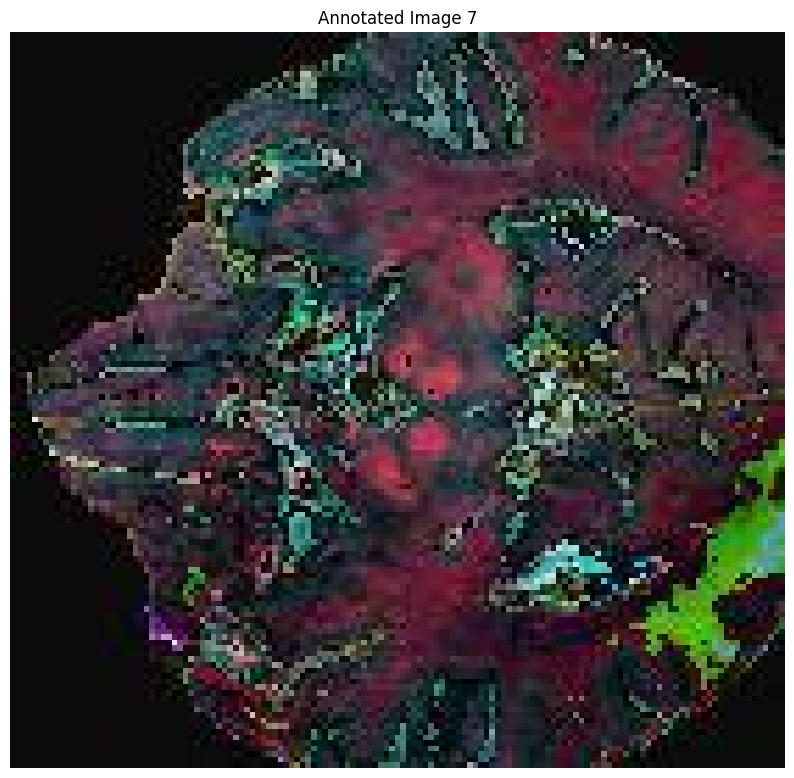

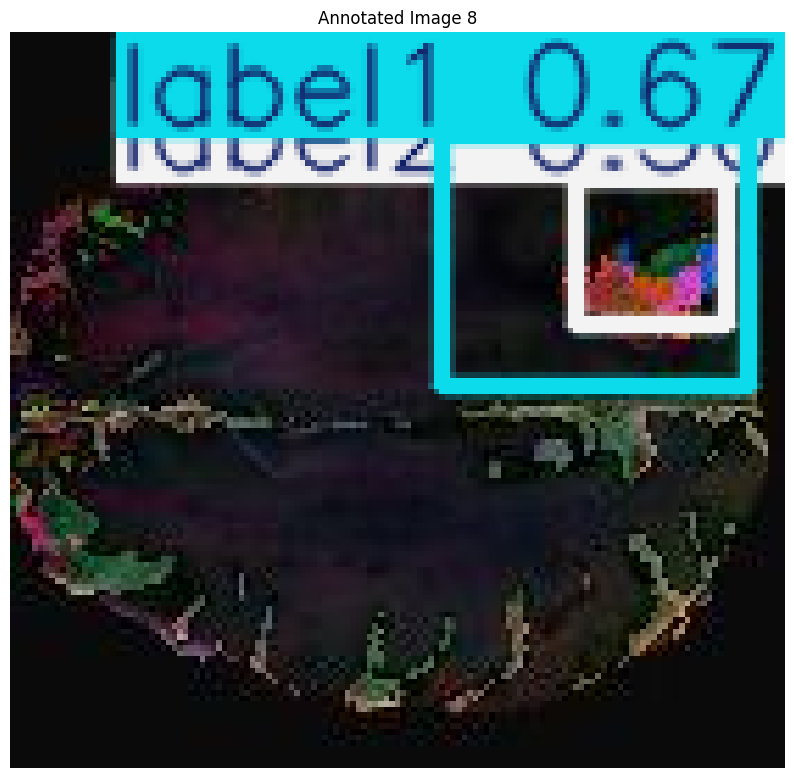

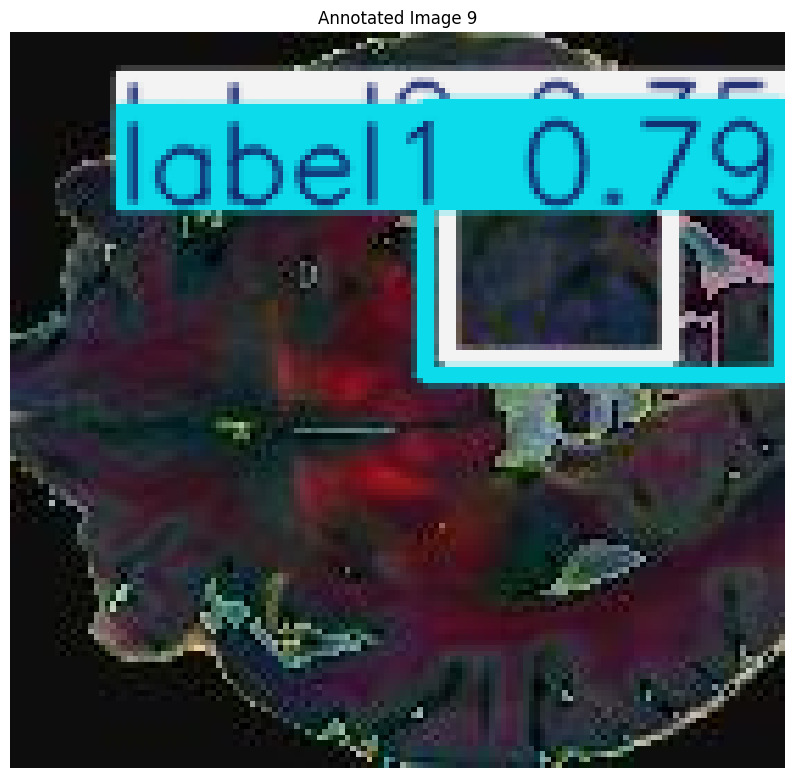

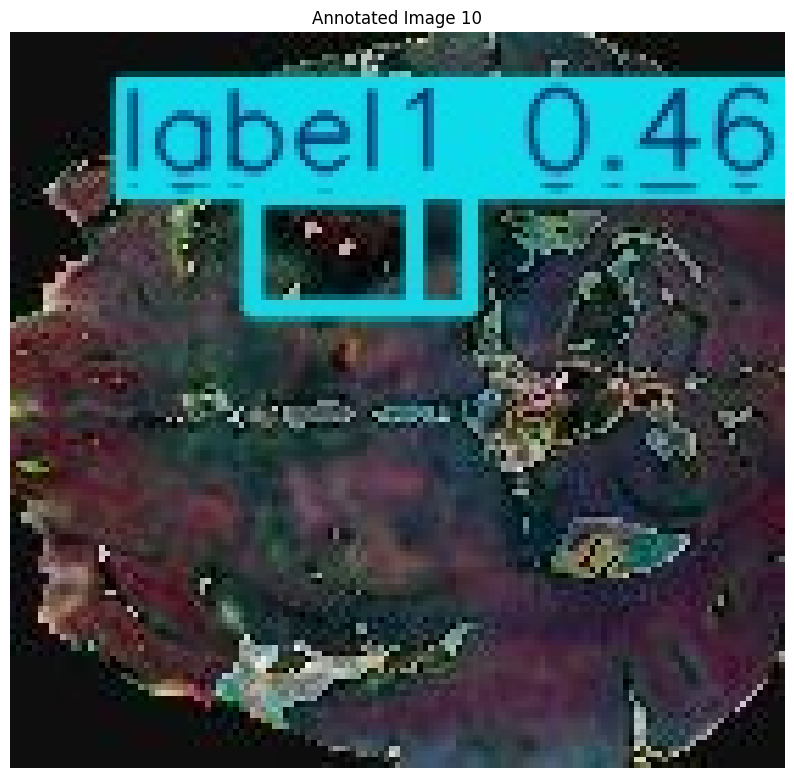

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if saved_images:
    img_path = saved_images[0]  # Select the first image
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No saved images found.")



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = [0, 1, 1, 0, 1, 0]
y_pred = [0, 1, 0, 0, 1, 1]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1 Score: 0.67


# **Normally Applying CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
model = build_cnn_model(input_shape)
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit the model
epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs
)

# Save the model
model.save('cnn_model.h5')


Epoch 1/50
75/75 [==============================] - 14s 160ms/step - loss: 0.0990 - accuracy: 0.9842 - val_loss: 0.0527 - val_accuracy: 0.9931
Epoch 2/50
75/75 [==============================] - 8s 101ms/step - loss: 0.0617 - accuracy: 0.9904 - val_loss: 0.0454 - val_accuracy: 0.9931
Epoch 3/50
75/75 [==============================] - 15s 204ms/step - loss: 0.0590 - accuracy: 0.9904 - val_loss: 0.0455 - val_accuracy: 0.9931
Epoch 4/50
75/75 [==============================] - 5s 69ms/step - loss: 0.0568 - accuracy: 0.9904 - val_loss: 0.0453 - val_accuracy: 0.9931
Epoch 5/50
75/75 [==============================] - 7s 94ms/step - loss: 0.0547 - accuracy: 0.9904 - val_loss: 0.0452 - val_accuracy: 0.9931
Epoch 6/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0515 - accuracy: 0.9904 - val_loss: 0.0467 - val_accuracy: 0.9931
Epoch 7/50
75/75 [==============================] - 5s 61ms/step - loss: 0.0441 - accuracy: 0.9904 - val_loss: 0.0434 - val_accuracy: 0.9931
Epoch 8/

In [ ]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, steps=validation_steps)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


18/18 [==============================] - 2s 89ms/step - loss: 0.1723 - accuracy: 0.9931
Validation Loss: 0.1723097711801529
Validation Accuracy: 0.9930555820465088


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define paths to test images and labels
base_dir = '/content/dataset'  # Replace with your actual base directory
test_image_dir = os.path.join(base_dir, 'BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/test/images')
test_label_dir = os.path.join(base_dir, 'BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/test/labels')

# Check if the directories exist
if not os.path.exists(test_image_dir):
    raise FileNotFoundError(f"Directory '{test_image_dir}' not found. Please check your dataset path.")
if not os.path.exists(test_label_dir):
    raise FileNotFoundError(f"Directory '{test_label_dir}' not found. Please check your dataset path.")

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize to [0,1]
    return image

# Function to load labels (assuming binary classification, update if necessary)
def load_labels(label_path):
    # Load label from file (dummy function, replace with actual implementation)
    return int(np.random.randint(2))  # Replace with actual label

# Get list of test images and labels
test_image_paths = [os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)]
test_label_paths = [os.path.join(test_label_dir, fname) for fname in os.listdir(test_label_dir)]

# Sample 10 random images and labels
sample_indices = np.random.choice(len(test_image_paths), size=10, replace=False)
sample_image_paths = [test_image_paths[i] for i in sample_indices]
sample_label_paths = [test_label_paths[i] for i in sample_indices]

# Load images and labels
test_images = [load_and_preprocess_image(p) for p in sample_image_paths]
test_labels = [load_labels(p) for p in sample_label_paths]

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Load your trained model
model_path = '/content/cnn_model.h5'  # Replace with your actual model path
model = tf.keras.models.load_model(model_path)

# Compile the model before evaluation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Make predictions on the test images
predictions = model.predict(test_images)


1/1 [==============================] - 1s 1s/step


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB mode
    image = image.resize(target_size)
    image_array = np.array(image)
    image_array = image_array / 255.0  # Normalize pixel values
    return image_array

target_size = (224, 224)  # Replace with your model's expected input size

# Load images
test_images = [load_and_preprocess_image(img_path, target_size) for img_path in test_image_paths]

# Convert list to numpy array
test_images = np.array(test_images)


# **Results**

1/1 [==============================] - 0s 73ms/step


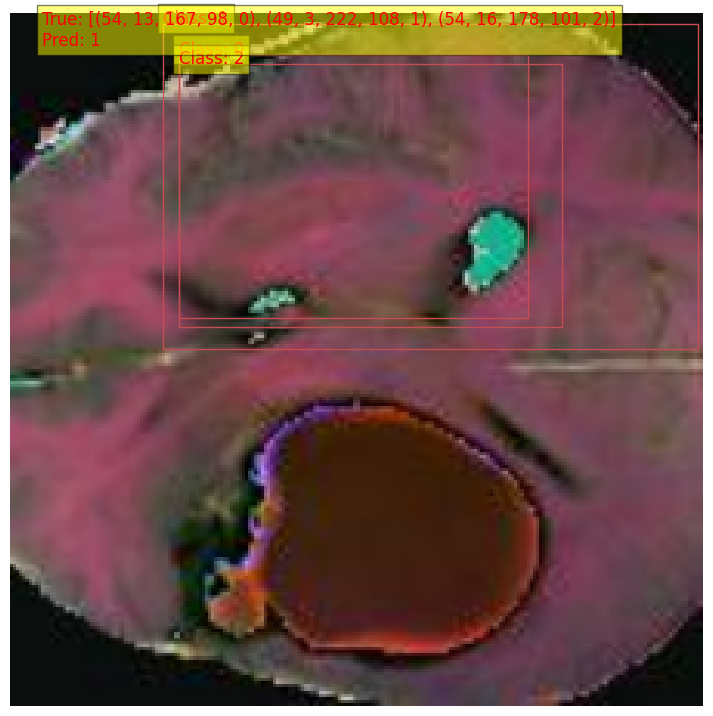

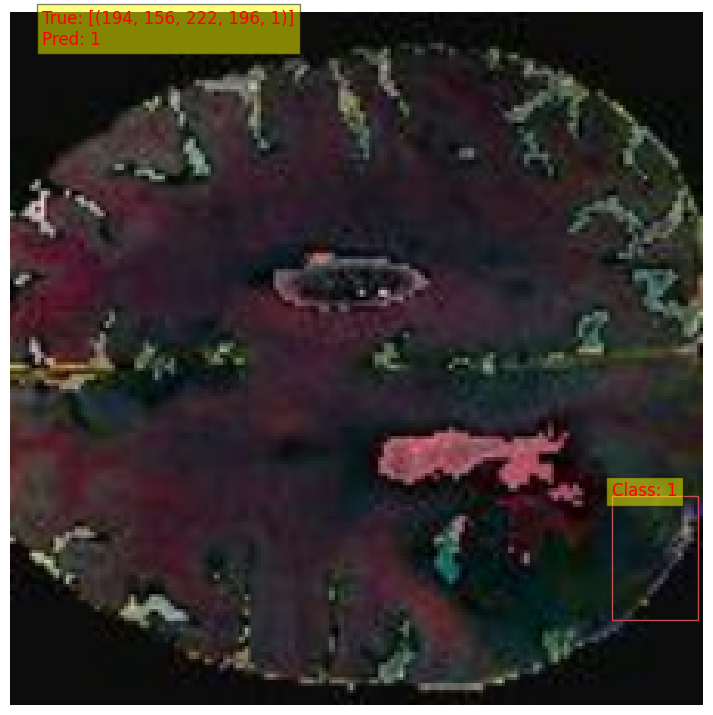

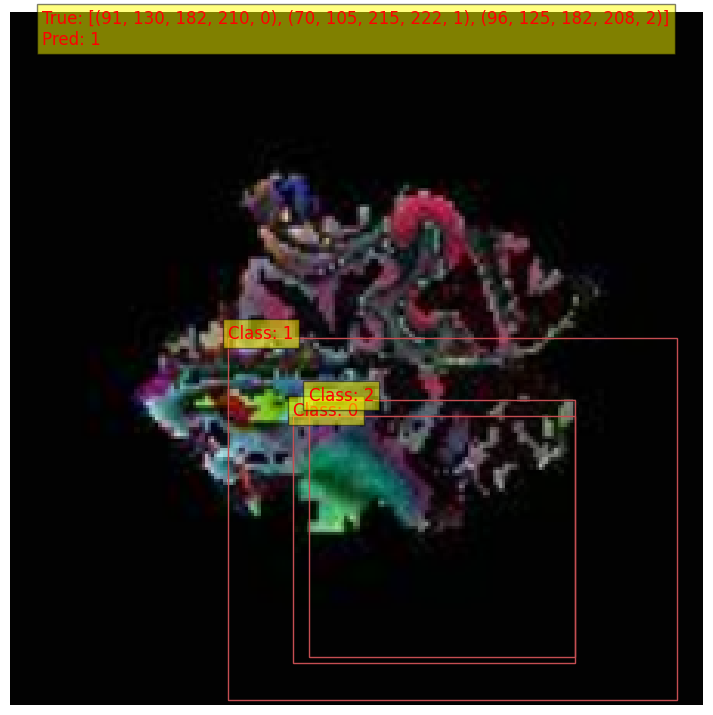

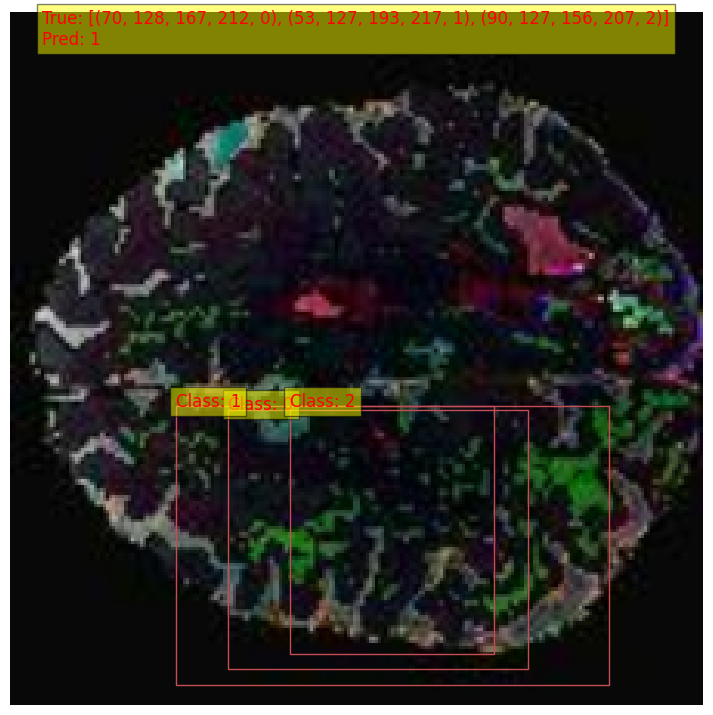

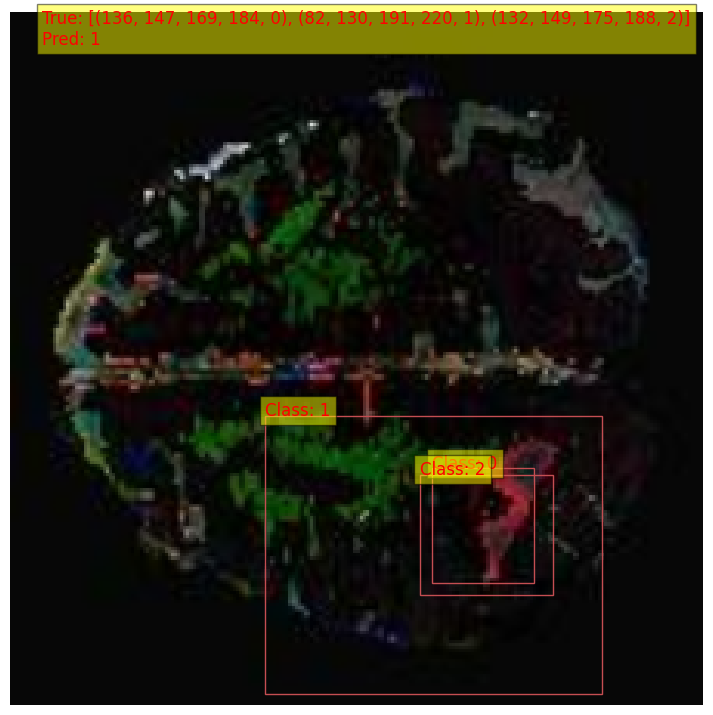

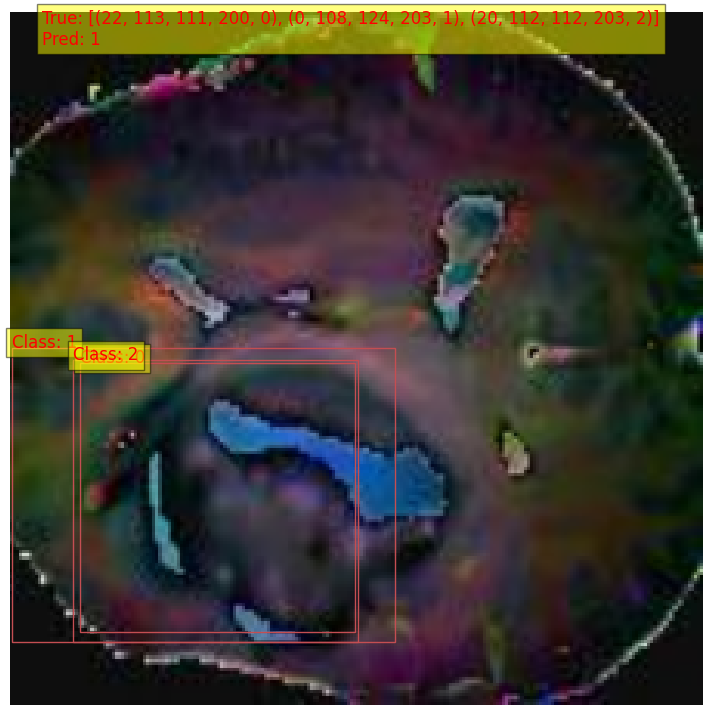

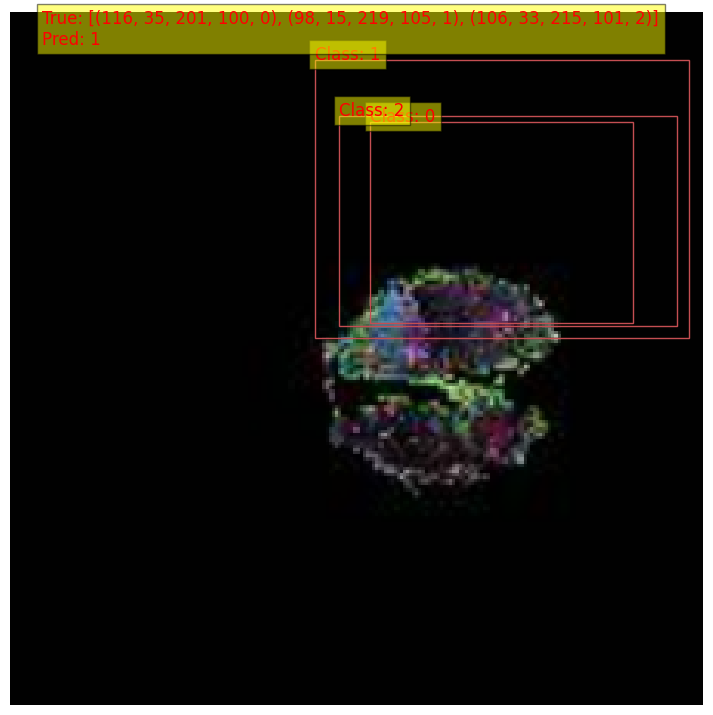

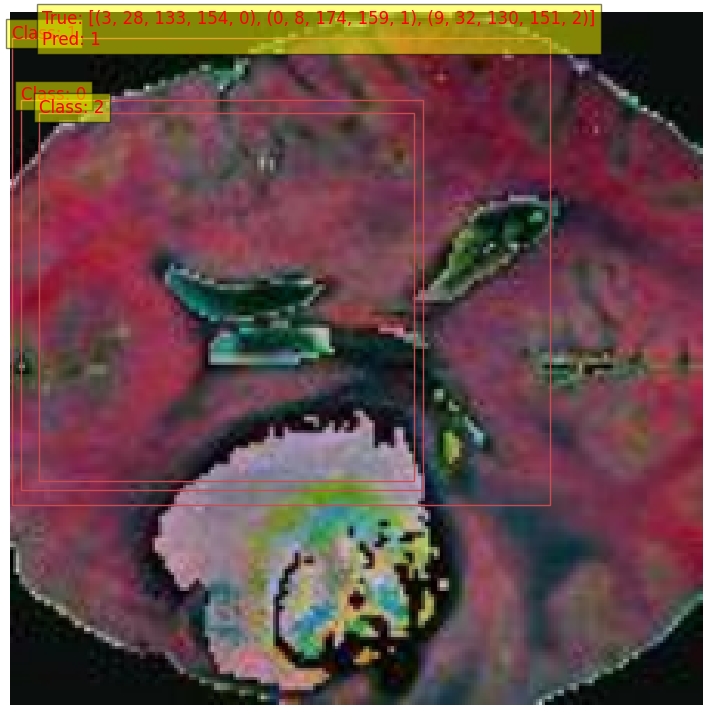

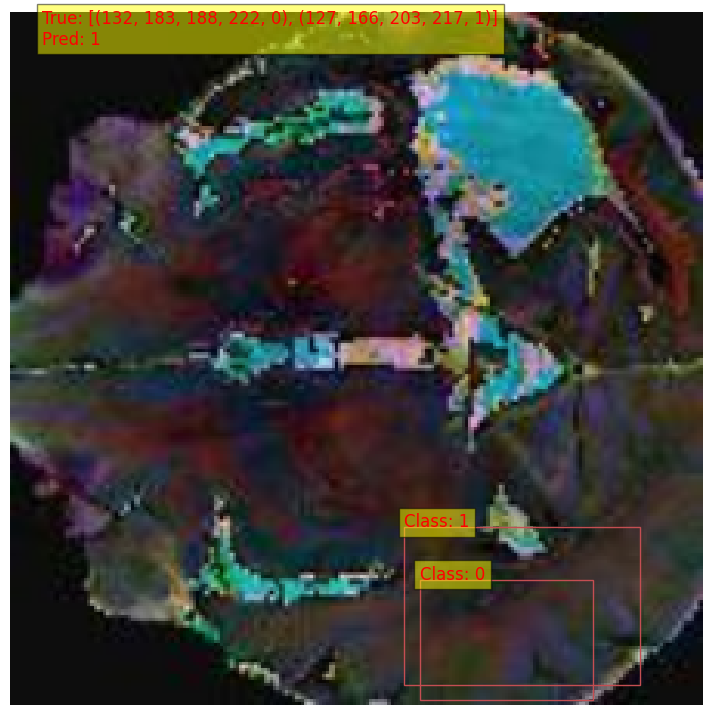

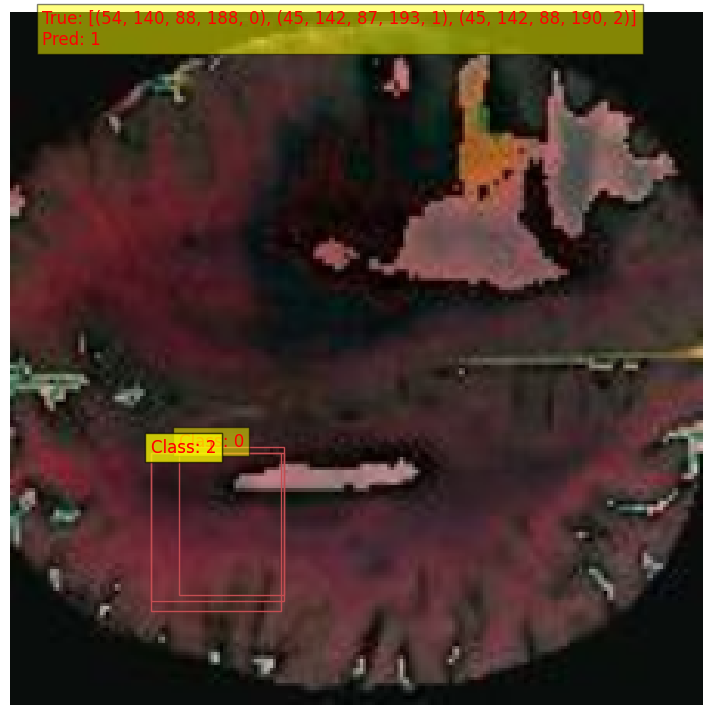

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as patches

# Define paths to test images and labels
base_dir = '/content/dataset'  # Replace with your actual base directory
test_image_dir = os.path.join(base_dir, 'BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/test/images')
test_label_dir = os.path.join(base_dir, 'BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/test/labels')

# Check if the directories exist
if not os.path.exists(test_image_dir):
    raise FileNotFoundError(f"Directory '{test_image_dir}' not found. Please check your dataset path.")
if not os.path.exists(test_label_dir):
    raise FileNotFoundError(f"Directory '{test_label_dir}' not found. Please check your dataset path.")

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize to [0,1]
    return image

# Function to load labels in YOLO format
def load_labels(label_path):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Convert normalized coordinates to absolute coordinates
                image_width = 224  # Replace with actual image width
                image_height = 224  # Replace with actual image height

                x_min = int((x_center - width / 2) * image_width)
                y_min = int((y_center - height / 2) * image_height)
                x_max = int((x_center + width / 2) * image_width)
                y_max = int((y_center + height / 2) * image_height)

                boxes.append((x_min, y_min, x_max, y_max, class_id))
    return boxes

# Get list of test images and labels
test_image_paths = [os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)]
test_label_paths = [os.path.join(test_label_dir, fname) for fname in os.listdir(test_label_dir)]

# Sample 10 random images and labels
sample_indices = np.random.choice(len(test_image_paths), size=10, replace=False)
sample_image_paths = [test_image_paths[i] for i in sample_indices]
sample_label_paths = [test_label_paths[i] for i in sample_indices]

# Load images and labels
test_images = [load_and_preprocess_image(p) for p in sample_image_paths]
test_labels = [load_labels(p) for p in sample_label_paths]

# Convert lists to numpy arrays
test_images = np.array(test_images)

# Load your trained model
model_path = '/content/cnn_model.h5'  # Replace with your actual model path
model = tf.keras.models.load_model(model_path)

# Compile the model before evaluation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Make predictions on the test images
predictions = model.predict(test_images)

# Convert predictions from probabilities to binary labels
predicted_labels = (predictions > 0.5).astype(int)

# Function to draw bounding boxes and labels
def draw_boxes(image, boxes, true_label, pred_label):
    fig, ax = plt.subplots(1, figsize=(12, 9))

    # Convert image from [0, 1] to [0, 255] for display
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    ax.imshow(image)
    for box in boxes:
        x_min, y_min, x_max, y_max, class_id = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min, f'Class: {class_id}', color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    # Display the true and predicted labels
    label_text = f'True: {true_label}\nPred: {pred_label}'
    plt.text(10, 10, label_text, color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Display images with true and predicted labels
for i in range(10):
    image = test_images[i]
    true_labels = test_labels[i]
    pred_label = predicted_labels[i][0]  # Extract the single predicted value
    draw_boxes(image, true_labels, true_labels, pred_label)




In [ ]:
def image_label_generator(image_label_pairs, batch_size, img_size):
    while True:
        batch_images = []
        batch_labels = []
        for image_path, label in image_label_pairs:
            image = load_img(image_path, target_size=img_size)
            image = img_to_array(image) / 255.0
            batch_images.append(image)
            batch_labels.append(label)
            if len(batch_images) == batch_size:
                yield np.array(batch_images), np.array(batch_labels)
                batch_images = []
                batch_labels = []

        # Ensure there are no residual batches left
        if batch_images:
            yield np.array(batch_images), np.array(batch_labels)



In [ ]:
# Test the image loading
def test_image_loading():
    for image_path, label in image_label_pairs[:5]:  # Test with first 5 images
        image = load_img(image_path, target_size=img_size)
        image = img_to_array(image) / 255.0
        print(f"Loaded image: {image_path}, Label: {label}")

test_image_loading()


Loaded image: dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/images/volume_350_slice_93_jpg.rf.12ec756eb02146f779336cb52c62a3c2.jpg, Label: 1
Loaded image: dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/images/volume_180_slice_60_jpg.rf.02906c493dc7623ba7b2b2cc58d35253.jpg, Label: 1
Loaded image: dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/images/volume_349_slice_72_jpg.rf.667148613c7aff6684d065af1ea7aae5.jpg, Label: 1
Loaded image: dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/images/volume_139_slice_100_jpg.rf.fd03408ddc2035e77baf41234aae5472.jpg, Label: 1
Loaded image: dataset/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/images/volume_268_slice_64_jpg.rf.f8b3750f659e4a559eb5790410e61c1d.jpg, Label: 1


In [ ]:
def image_label_generator(image_label_pairs, batch_size, img_size):
    while True:
        batch_images = []
        batch_labels = []
        for image_path, label in image_label_pairs:
            image = load_img(image_path, target_size=img_size)
            image = img_to_array(image) / 255.0
            batch_images.append(image)
            batch_labels.append(label)
            if len(batch_images) == batch_size:
                yield np.array(batch_images), np.array(batch_labels)
                batch_images = []
                batch_labels = []
        if batch_images:  # Ensure any remaining data is yielded
            yield np.array(batch_images), np.array(batch_labels)



In [ ]:
small_subset = image_label_pairs[:100]  # Take a small subset for testing
test_generator = image_label_generator(small_subset, batch_size, img_size)

for i in range(5):  # Fetch 5 batches
    batch_images, batch_labels = next(test_generator)
    print(f"Batch {i+1} images shape: {batch_images.shape}")
    print(f"Batch {i+1} labels shape: {batch_labels.shape}")


Batch 1 images shape: (32, 224, 224, 3)
Batch 1 labels shape: (32,)
Batch 2 images shape: (32, 224, 224, 3)
Batch 2 labels shape: (32,)
Batch 3 images shape: (32, 224, 224, 3)
Batch 3 labels shape: (32,)
Batch 4 images shape: (4, 224, 224, 3)
Batch 4 labels shape: (4,)
Batch 5 images shape: (32, 224, 224, 3)
Batch 5 labels shape: (32,)


In [ ]:
# Check a single batch from the validation generator
try:
    batch_images, batch_labels = next(val_generator)
    print("Single batch images shape:", batch_images.shape)
    print("Single batch labels shape:", batch_labels.shape)
except StopIteration:
    print("Validation generator has no data.")


Single batch images shape: (32, 224, 224, 3)
Single batch labels shape: (32,)


In [ ]:
print("Number of training pairs:", len(train_pairs))
print("Number of validation pairs:", len(val_pairs))


Number of training pairs: 2400
Number of validation pairs: 600


In [ ]:
# Fetch predictions with debugging
y_pred_prob = []
try:
    for _ in range(validation_steps):
        batch_prob = model.predict(val_generator, steps=1)
        y_pred_prob.extend(batch_prob)
except StopIteration:
    pass

# Convert to numpy array
y_pred_prob = np.array(y_pred_prob).flatten()
print("Length of y_pred_prob:", len(y_pred_prob))

# Extract true labels with debugging
y_true = []
try:
    for _ in range(validation_steps):
        _, batch_labels = next(val_generator)
        y_true.extend(batch_labels)
except StopIteration:
    pass

# Convert to numpy array
y_true = np.array(y_true).flatten()
print("Length of y_true:", len(y_true))

# Check if arrays are non-empty
if len(y_pred_prob) > 0 and len(y_true) > 0:
    # Ensure lengths match
    assert len(y_pred_prob) == len(y_true), "Mismatch between lengths of predictions and true labels"

    # Calculate metrics
    y_pred = (y_pred_prob > 0.5).astype(int)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
else:
    print("Predictions or true labels are empty. Cannot calculate metrics.")



1/1 [==============================] - 0s 63ms/step
Length of y_pred_prob: 568
Length of y_true: 568
Accuracy: 0.9929577464788732
F1 Score: 0.9964664310954063
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      1.00      1.00       564

    accuracy                           0.99       568
   macro avg       0.50      0.50      0.50       568
weighted avg       0.99      0.99      0.99       568



# **SVM**

In [ ]:
pip install numpy scikit-learn opencv-python


In [ ]:
import cv2
import numpy as np
import os
import time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Function to load images from a folder and assign labels
def load_images_with_labels(folder, label_file, image_size=(64, 64), max_images=3000):
    images = []
    labels = []
    label_dict = {}

    # Read the labels from the label file (assuming it's a CSV with 'filename,label' format)
    with open(label_file, 'r') as f:
        for line in f:
            filename, label = line.strip().split(',')
            label_dict[filename] = int(label)

    for i, filename in enumerate(os.listdir(folder)):
        if i >= max_images:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = img.flatten()  # Flatten the image
            images.append(img)
            labels.append(label_dict.get(filename, 0))  # Default to label 0 if not found

    return np.array(images), np.array(labels)

# Paths to the dataset folder and label file
base_path = '/content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/images'
label_file = '/content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/labels.csv'  # Path to your label file

# Verify if the paths exist
if not os.path.exists(base_path):
    print(f"Base path does not exist: {base_path}")
else:
    print(f"Subdirectories and files in base path: {os.listdir(base_path)}")

# Load images and labels
if os.path.exists(base_path) and os.path.exists(label_file):
    images, labels = load_images_with_labels(base_path, label_file)

    # Combine and split the data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Subdirectories and files in base path: ['volume_115_slice_68_jpg.rf.31e14ff796678823674977375674c4fa.jpg', 'volume_224_slice_68_jpg.rf.6ccf6a35627ab7c970ac7ba5aae41837.jpg', 'volume_64_slice_67_jpg.rf.390a1ae90590ab1543572928bf114cb7.jpg', 'volume_167_slice_62_jpg.rf.555aeac10a86ace9f1ad581dd0b86b75.jpg', 'volume_201_slice_130_jpg.rf.21662cb571ab5f68491ab1f00994348d.jpg', 'volume_312_slice_99_jpg.rf.a5f8602a17a040b1ce53ead2652f8d65.jpg', 'volume_116_slice_49_jpg.rf.273ca3ebfe7edd6738521205afbe0238.jpg', 'volume_101_slice_35_jpg.rf.0cda8e186e8300083440eb61c728d0c4.jpg', 'volume_58_slice_91_jpg.rf.8107ebb7dcf0d6662a8ccceb0ab5c13d.jpg', 'volume_294_slice_71_jpg.rf.5df3d255b1f804b448fbd6f6f570184b.jpg', 'volume_126_slice_60_jpg.rf.9eec4931c6469fae0089d7acde8420c8.jpg', 'volume_49_slice_121_jpg.rf.76e33ed67d31223c7f749e07a2b66146.jpg', 'volume_95_slice_124_jpg.rf.fe5335a177925dbbfa579dd5c1755155.jpg', 'volume_38_slice_50_jpg.rf.d5126e6a0d21b051beb243d55dfa532a.jpg', 'volume_170_slice_40_jpg

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import random

# Define your base path and label file if available
base_path = '/content/dataset/BrainTumorDetectionYolov9/BrainTumorDetectionYolov9/train/images/'
max_images = 3000

# Function to load a limited number of images from the base path
def load_images_from_base_path(base_path, label, max_images, image_size=(128, 128)):
    images = []
    labels = []
    filenames = [f for f in os.listdir(base_path) if f.endswith('.jpg')]
    random.shuffle(filenames)  # Shuffle filenames to get a random sample
    for filename in filenames[:max_images]:
        img_path = os.path.join(base_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)  # Resize to a common size
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
        images.append(img)
        labels.append(label)
    return images, labels

# Example to load images; you need to specify your labeling mechanism
tumor_images, tumor_labels = load_images_from_base_path(base_path, 1, max_images // 2)
no_tumor_images, no_tumor_labels = load_images_from_base_path(base_path, 0, max_images // 2)  # Adjust labeling as necessary

# Combine data
X = np.array(tumor_images + no_tumor_images)
y = np.array(tumor_labels + no_tumor_labels)

# Flatten images if needed (for SVM)
X = X.reshape(X.shape[0], -1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.4216666666666667
F1 Score: 0.42833607907742993
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.43      0.41       287
           1       0.44      0.42      0.43       313

    accuracy                           0.42       600
   macro avg       0.42      0.42      0.42       600
weighted avg       0.42      0.42      0.42       600



# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest Accuracy:", accuracy)
print("Random Forest F1 Score:", f1)
print("Random Forest Classification Report:\n", report)

Random Forest Accuracy: 0.4066666666666667
Random Forest F1 Score: 0.41830065359477125
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.40      0.39       287
           1       0.43      0.41      0.42       313

    accuracy                           0.41       600
   macro avg       0.41      0.41      0.41       600
weighted avg       0.41      0.41      0.41       600



# **K-Nearest Neighbors (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on test data
y_pred = knn_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("KNN Accuracy:", accuracy)
print("KNN F1 Score:", f1)
print("KNN Classification Report:\n", report)

KNN Accuracy: 0.45166666666666666
KNN F1 Score: 0.4072072072072072
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.55      0.49       287
           1       0.47      0.36      0.41       313

    accuracy                           0.45       600
   macro avg       0.45      0.46      0.45       600
weighted avg       0.45      0.45      0.45       600



# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1 Score:", f1)
print("Logistic Regression Classification Report:\n", report)

Logistic Regression Accuracy: 0.4
Logistic Regression F1 Score: 0.40397350993377484
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.41      0.40       287
           1       0.42      0.39      0.40       313

    accuracy                           0.40       600
   macro avg       0.40      0.40      0.40       600
weighted avg       0.40      0.40      0.40       600



# **Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predict on test data
y_pred = gb_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Gradient Boosting Accuracy:", accuracy)
print("Gradient Boosting F1 Score:", f1)
print("Gradient Boosting Classification Report:\n", report)

Gradient Boosting Accuracy: 0.4083333333333333
Gradient Boosting F1 Score: 0.40536013400335014
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.43      0.41       287
           1       0.43      0.39      0.41       313

    accuracy                           0.41       600
   macro avg       0.41      0.41      0.41       600
weighted avg       0.41      0.41      0.41       600

